# 2023-12-short-courses-universe

Main focus of notebook: visualise the 'universe' of content-mapped short courses.

### Context
Such as visualisation can help with communication and specifically for:
* identification of course gaps
* Marketing Team and category assignments
* Content and Growth Team on course catalogue planning

### Stakeholders
Separate stakeholders for different purposes

## Additional information on the project and notebook
Project: various
Orginal Author: Elena Hensinger-Schien
Current editor: Andria Ellis

---

# Executive summary

The code provides an effective visualisation tool and data for all short courses of FutureLearn.   
It maps courses as dots in a 2-dimensional spacial map, with courses with similar content closer to each other.   
Colour coding by first category enables exploration of the course catalogue, showing that the assignment of categories is not always ideal.   
Automated clustering is then deployed to search for clusters of similar content, and word cloud of these courses' topics to help compare and assess this clustering.   

This approach enables automated analysis of FutureLearn's course catalogue, and provides a powerful tool for its strategic management.
---

## Data used
* 1,609 short courses
* embeddings computed on the following sections of the CDP pages of those courses: title, introduction sentence, topics covered, course outcomes

* file name: 'courses-with-embeddings-2024-01-18.pickle'
---

## Data generated
List here any files (pickle, csv) that are created within this notebook:
* file name, location (either Github directory or Google Drive directory)
* next file name ...

---

In [175]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install umap-learn
#!{sys.executable} -m pip install colorcet
#!{sys.executable} -m pip install hdbscan

In [176]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import hdbscan

In [177]:
# Import data - we use an existing dataset from the project '2023-10-Prospective-courses-insights'
df = pd.read_pickle("/Users/andriaellis/Desktop/courses-with-embeddings-2024-01-10.pickle")
df.shape

# 1,609 short courses from original dataset

df2 = pd.read_csv('/Users/andriaellis/Desktop/course_features_latestrun.csv')
df2.shape

# 5,349 short courses from course feature dataset

result_df = pd.merge(df, df2, on='COURSE_SLUG', how='inner')
result_df.shape

(1683, 13)

In [178]:
result_df.head(20)

result_df.describe()
result_df.info()
#dupes=df[result_df['COURSE_SLUG'].unique()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   COURSE_SLUG               1683 non-null   object 
 1   COURSE_NAME               1683 non-null   string 
 2   FIRST_CATEGORY            1683 non-null   string 
 3   SECOND_CATEGORY           864 non-null    string 
 4   TOPICS_ARRAY              1683 non-null   object 
 5   CATEGORIES_ARRAY          1683 non-null   object 
 6   DIFFICULTY_LEVEL          1640 non-null   string 
 7   concatenated_cdp_content  1683 non-null   object 
 8   embeddings                1683 non-null   object 
 9   GMV                       1009 non-null   float64
 10  N_COMPLETIONS             1660 non-null   float64
 11  N_ENROLMENTS              1660 non-null   float64
 12  N_VISITORS_TO_CDP         1683 non-null   int64  
dtypes: float64(3), int64(1), object(5), string(4)
memory usage: 171

In [179]:
# course universe, grouped by first category
result_df.groupby("FIRST_CATEGORY").size().sort_values(ascending=False)

FIRST_CATEGORY
business_and_management          360
healthcare_medicine              307
it_and_computer_science          146
nature_and_environment           145
creative_arts_and_media          121
teaching                         116
science_engineering_and_maths     86
language                          82
politics_and_society              81
psychology_and_mental_health      71
history                           63
study_skills                      55
law                               37
literature                        13
dtype: int64

In [180]:
# in percent
result_df.value_counts("FIRST_CATEGORY",normalize=True,dropna=False)*100

FIRST_CATEGORY
business_and_management          21.390374
healthcare_medicine              18.241236
it_and_computer_science           8.674985
nature_and_environment            8.615567
creative_arts_and_media           7.189542
teaching                          6.892454
science_engineering_and_maths     5.109923
language                          4.872252
politics_and_society              4.812834
psychology_and_mental_health      4.218657
history                           3.743316
study_skills                      3.267974
law                               2.198455
literature                        0.772430
Name: proportion, dtype: float64

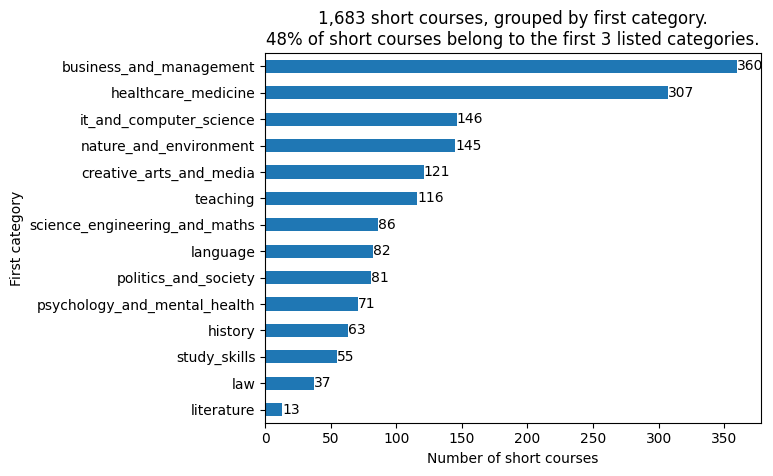

In [181]:
ax = result_df.groupby("FIRST_CATEGORY").size().sort_values(ascending=True).plot(kind='barh',title='{:,}'.format(len(df))+" short courses, grouped by first category.\n48% of short courses belong to the first 3 listed categories.",xlabel="Number of short courses", ylabel="First category")
ax.bar_label(ax.containers[0]); # shows values in chart

In [182]:
# how many unique first categories?
result_df.FIRST_CATEGORY.nunique()

14

In [183]:
# sort data alphabetically by first category
result_df.sort_values("FIRST_CATEGORY",ascending=True,inplace=True)

In [184]:
# the colours we will be using:
cc.glasbey[:14]

['#d60000',
 '#8c3bff',
 '#018700',
 '#00acc6',
 '#97ff00',
 '#ff7ed1',
 '#6b004f',
 '#ffa52f',
 '#573b00',
 '#005659',
 '#0000dd',
 '#00fdcf',
 '#a17569',
 '#bcb6ff']

### the colours we will be using (last one changed):
['#d60000',
 '#8c3bff',
 '#018700',
 '#00acc6',
 '#97ff00',
 '#ff7ed1',
 '#6b004f',
 '#ffa52f',
 '#573b00',
 '#005659',
 '#0000dd',
 '#00fdcf',
 '#a17569',
 '#fce807']

 NOTE: the original glasbey pallette has got '#bcb6ff' as the 14th colour; but it is very difficult to see on the individual plot

In [185]:
# the categories mapped to the colours
result_df.FIRST_CATEGORY.unique()

<StringArray>
[      'business_and_management',       'creative_arts_and_media',
           'healthcare_medicine',                       'history',
       'it_and_computer_science',                      'language',
                           'law',                    'literature',
        'nature_and_environment',          'politics_and_society',
  'psychology_and_mental_health', 'science_engineering_and_maths',
                  'study_skills',                      'teaching']
Length: 14, dtype: string

### the categories mapped to the colours - ordered alphabetically
[      'business_and_management',       'creative_arts_and_media',
           'healthcare_medicine',                       'history',
       'it_and_computer_science',                      'language',
                           'law',                    'literature',
        'nature_and_environment',          'politics_and_society',
  'psychology_and_mental_health', 'science_engineering_and_maths',
                  'study_skills',                      'teaching']

---

### Second approach for dimensionality reduction: UMAP

a general purpose manifold learning and dimension reduction algorithm.

In [186]:
# initiate the reducer
reducer_2_dim = umap.UMAP(n_components=2,random_state=42)

In [187]:
# take the embeddings and use umap to create a 2-dim mapping
reducer_2_dim.fit(np.array(result_df.embeddings.to_list()))

# source: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# To access the resulting transform we can either look at the embedding_ attribute of the reducer object, or call transform on the original data.

/opt/homebrew/Cellar/jupyterlab/4.0.9_2/libexec/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [188]:
embedding_2_dim = reducer_2_dim.transform(np.array(result_df.embeddings.to_list()))
result_df[["X", "Y"]] = embedding_2_dim
result_df.sample(2)

COURSE_SLUG  \
1237                   outdoor-fitness-business-sc   
1646  harnessing-ai-in-marketing-and-communication   

                                            COURSE_NAME  \
1237  Personal Trainer's Toolkit: Build an Outdoor F...   
1646       Harnessing AI in Marketing and Communication   

               FIRST_CATEGORY               SECOND_CATEGORY  \
1237      healthcare_medicine  psychology_and_mental_health   
1646  business_and_management       it_and_computer_science   

                                           TOPICS_ARRAY  \
1237                                [Personal Training]   
1646  [Generative AI, Artificial Intelligence (AI), ...   

                                       CATEGORIES_ARRAY DIFFICULTY_LEVEL  \
1237  [Psychology & Mental Health, Healthcare & Medi...             <NA>   
1646     [IT & Computer Science, Business & Management]     Introductory   

                               concatenated_cdp_content  \
1237  Personal Trainer's Toolkit: Build an Outdoor F...   
1646  Harnessing AI in Marketing and Communication L...   

                                             embeddings     GMV  \
1237  [0.021479373797774315, -0.02012278139591217, -...     NaN   
1646  [-0.00817781500518322, -0.0054540857672691345,...  1405.0   

      N_COMPLETIONS  N_ENROLMENTS  N_VISITORS_TO_CDP          X         Y  
1237            5.0          29.0                200  10.978379  4.613627  
1646           53.0        4503.0              22735  10.668496 -2.208467

In [189]:
# we need to konw min and max coordinate values to set plot ranges

# NOTE: IF the dataset changes, and thus the UMAP embeddings computation, THEN we need to check and possibly adapt the ranges!
# Best approach is to compute the UMAP embeddings once, then export, and use that file for any future visualisation work

result_df[["X", "Y"]].describe()

# suggested ranges for plots, based on min and max values:
# X: [4.5,14.5]
# Y: [-1.5,9]

X            Y
count  1683.000000  1683.000000
mean     10.035775     1.241604
std       2.020310     2.570808
min       4.965162    -4.091903
25%       8.799794    -0.654643
50%      10.027737     1.164088
75%      11.616104     3.186739
max      14.160922     6.388682

---

Quick additional step of saving the mapped dataset, and the fitted model

In [190]:
# export the dataset with the UMAP embeddings
#df.to_pickle('../data/short-courses-UMAP-2dim-embeddings.pkl')

In [191]:
# let's also save the fitted model, for future use
# following steps from https://github.com/lmcinnes/umap/issues/178
import pickle

In [192]:
describe_df=result_df.describe()
result_df.describe()

GMV  N_COMPLETIONS  N_ENROLMENTS  N_VISITORS_TO_CDP  \
count   1009.00000    1660.000000   1660.000000        1683.000000   
mean     578.61447      61.117470    437.721687        1926.474747   
std     2636.68491     327.221118   1179.206579        5268.621744   
min       10.00000       0.000000      0.000000          80.000000   
25%       99.00000       7.000000     69.000000         464.000000   
50%      178.00000      15.000000    162.000000         837.000000   
75%      389.00000      37.000000    368.250000        1596.500000   
max    39541.00000   10553.000000  17611.000000      108746.000000   

                 X            Y  
count  1683.000000  1683.000000  
mean     10.035775     1.241604  
std       2.020310     2.570808  
min       4.965162    -4.091903  
25%       8.799794    -0.654643  
50%      10.027737     1.164088  
75%      11.616104     3.186739  
max      14.160922     6.388682

(0.0, 4000.0)

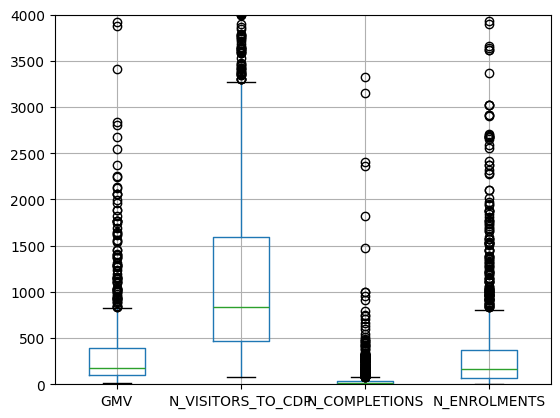

In [197]:
boxplot = result_df.boxplot(column=['GMV','N_VISITORS_TO_CDP','N_COMPLETIONS','N_ENROLMENTS'])  
plt.ylim(0, 4000)


In [232]:
result_df['GMV']=result_df['GMV'].fillna(0)
result_df['N_VISITORS_TO_CDP']=result_df['N_VISITORS_TO_CDP'].fillna(0)
result_df['N_COMPLETIONS']=result_df['N_COMPLETIONS'].fillna(0)
result_df['N_ENROLMENTS']=result_df['N_ENROLMENTS'].fillna(0)

In [233]:
max_gmv=(describe_df['GMV']['75%']-describe_df['GMV']['25%'])*1.5+describe_df['GMV']['75%']
max_cdp_visits=(describe_df['N_VISITORS_TO_CDP']['75%']-describe_df['N_VISITORS_TO_CDP']['25%'])*1.5+describe_df['N_VISITORS_TO_CDP']['75%']
max_completions=(describe_df['N_COMPLETIONS']['75%']-describe_df['N_COMPLETIONS']['25%'])*1.5+describe_df['N_COMPLETIONS']['75%']
max_enrolments=(describe_df['N_ENROLMENTS']['75%']-describe_df['N_ENROLMENTS']['25%'])*1.5+describe_df['N_ENROLMENTS']['75%']

In [234]:
bins_gmv = [-np.inf,0,describe_df['GMV']['25%'], describe_df['GMV']['50%'],describe_df['GMV']['75%'], max_gmv,describe_df['GMV']['max']]
bins_cdp_visits = [-np.inf,0,describe_df['N_VISITORS_TO_CDP']['25%'],describe_df['N_VISITORS_TO_CDP']['50%'],describe_df['N_VISITORS_TO_CDP']['75%'], max_cdp_visits,describe_df['N_VISITORS_TO_CDP']['max']]
bins_completions = [-np.inf,0,describe_df['N_COMPLETIONS']['25%'],describe_df['N_COMPLETIONS']['50%'],describe_df['N_COMPLETIONS']['75%'], max_completions,describe_df['N_COMPLETIONS']['max']]
bins_enrolments = [-np.inf,0,describe_df['N_ENROLMENTS']['25%'],describe_df['N_ENROLMENTS']['50%'],describe_df['N_ENROLMENTS']['75%'], max_enrolments,describe_df['N_ENROLMENTS']['max']]


In [295]:
bins_cdp_visits

[-inf, 0, 464.0, 837.0, 1596.5, 3295.25, 108746.0]

In [236]:
labels = [0,1,2,3,4,5]

In [237]:
result_df['gmv_level'] = pd.cut(result_df['GMV'], bins_gmv, labels=labels)

In [242]:

result_df['gmv_level'] = pd.cut(result_df['GMV'], bins_gmv, labels=labels)
result_df['visit_level'] = pd.cut(result_df['N_VISITORS_TO_CDP'], bins_cdp_visits, labels=labels)
result_df['completion_level'] = pd.cut(result_df['N_COMPLETIONS'], bins_completions, labels=labels)
result_df['enrolment_level'] = pd.cut(result_df['N_ENROLMENTS'], bins_enrolments, labels=labels)

In [252]:
result_df['gmv_level'] = result_df['gmv_level'].replace({'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5})
result_df['visit_level'] = result_df['visit_level'].replace({'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5})
result_df['completion_level'] = result_df['completion_level'].replace({'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5})
result_df['enrolment_level'] = result_df['enrolment_level'].replace({'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5})


In [260]:
grey_to_red=['#DADADA','#E0B5B5','#E69393','#ED6969','#F44242','#FF0000']

---

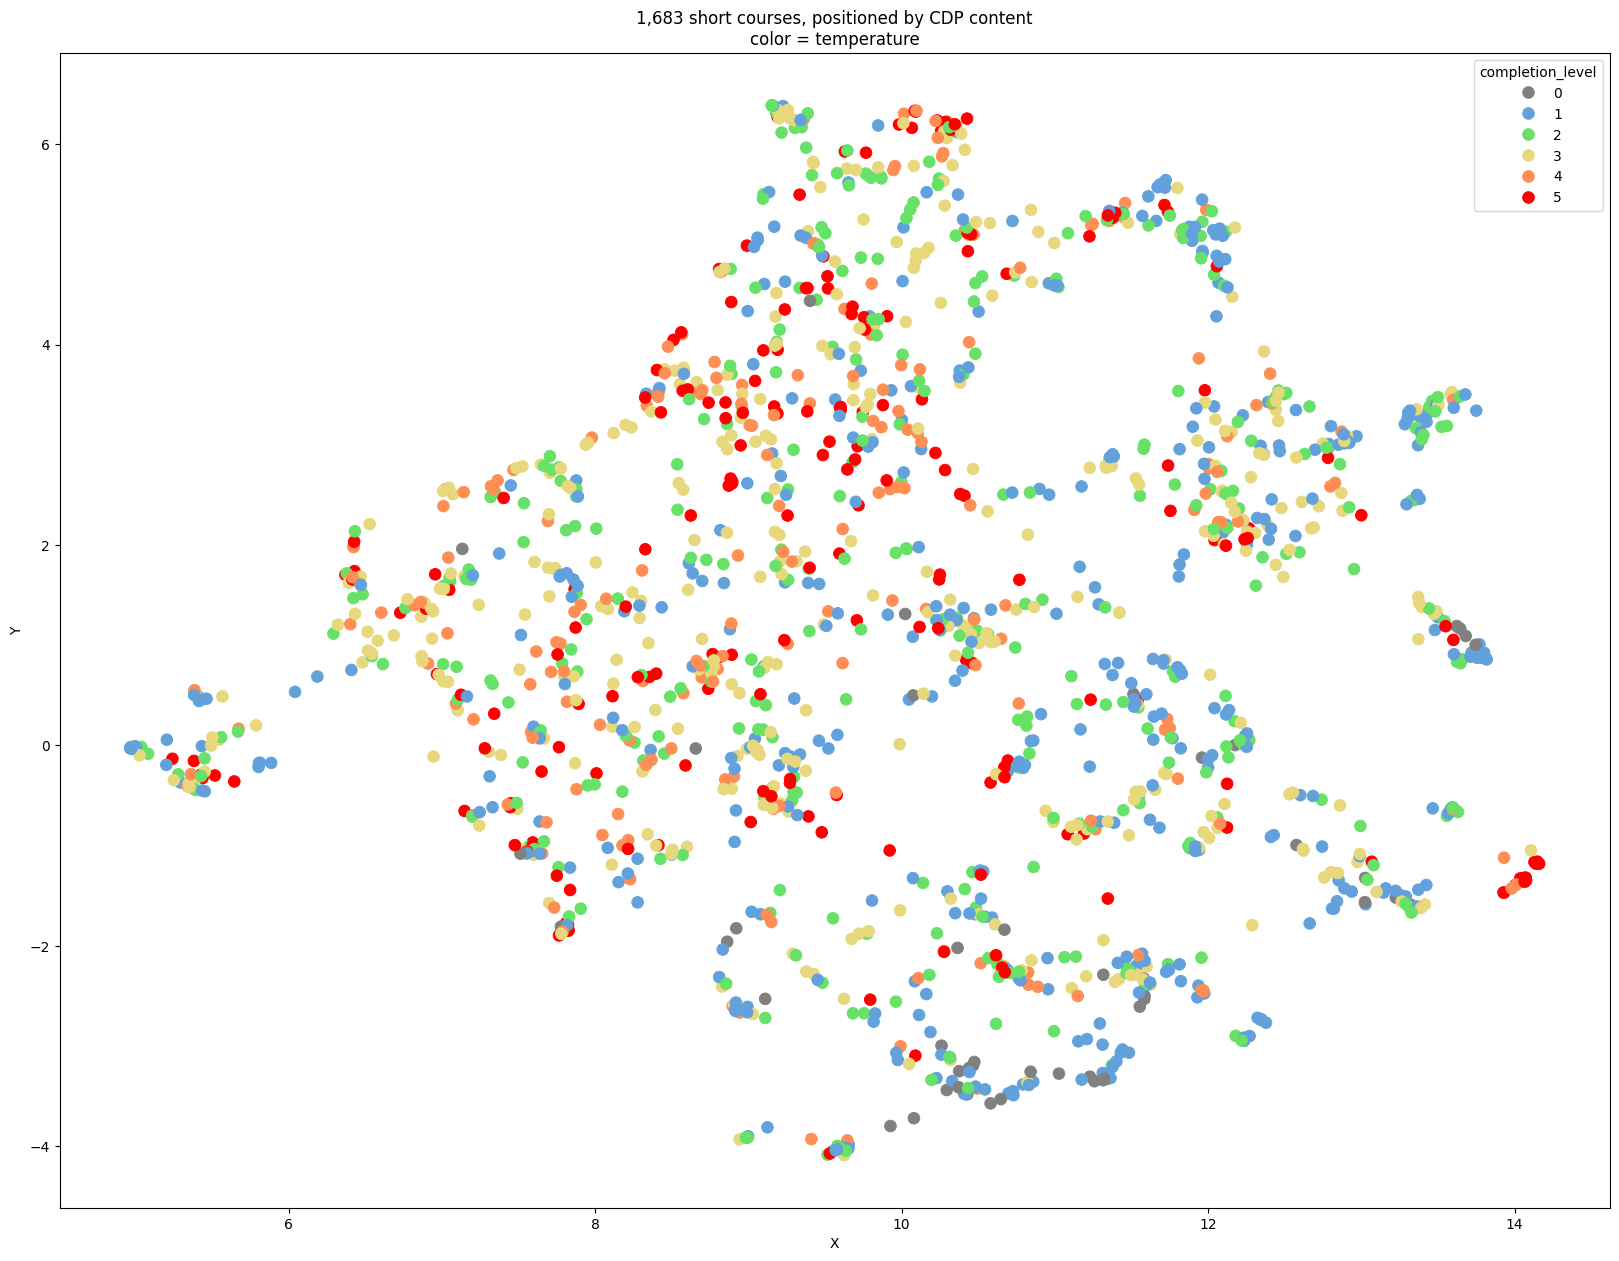

In [292]:
palette_orig = ['grey','#62a1db','#67E167','#e7d87d','#FF8E55','#FF0000']

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Use scatterplot and specify the "temperature" column for color
g = sns.scatterplot(data=result_df,
                    x="X",
                    y="Y",
                    hue="completion_level", ## gmv_level, visit_level, enrolment_level, completion_level
                    ax=ax,
                    ec="face",  # hollow and outlined markers
                    palette = palette_orig,
                    s=70)

ax.set_title('{:,}'.format(len(df)) + " short courses, positioned by CDP content\ncolor = temperature")
ax.set_xlabel("X")
ax.set_ylabel("Y")


plt.show()

Text(0, 0.5, 'Y')

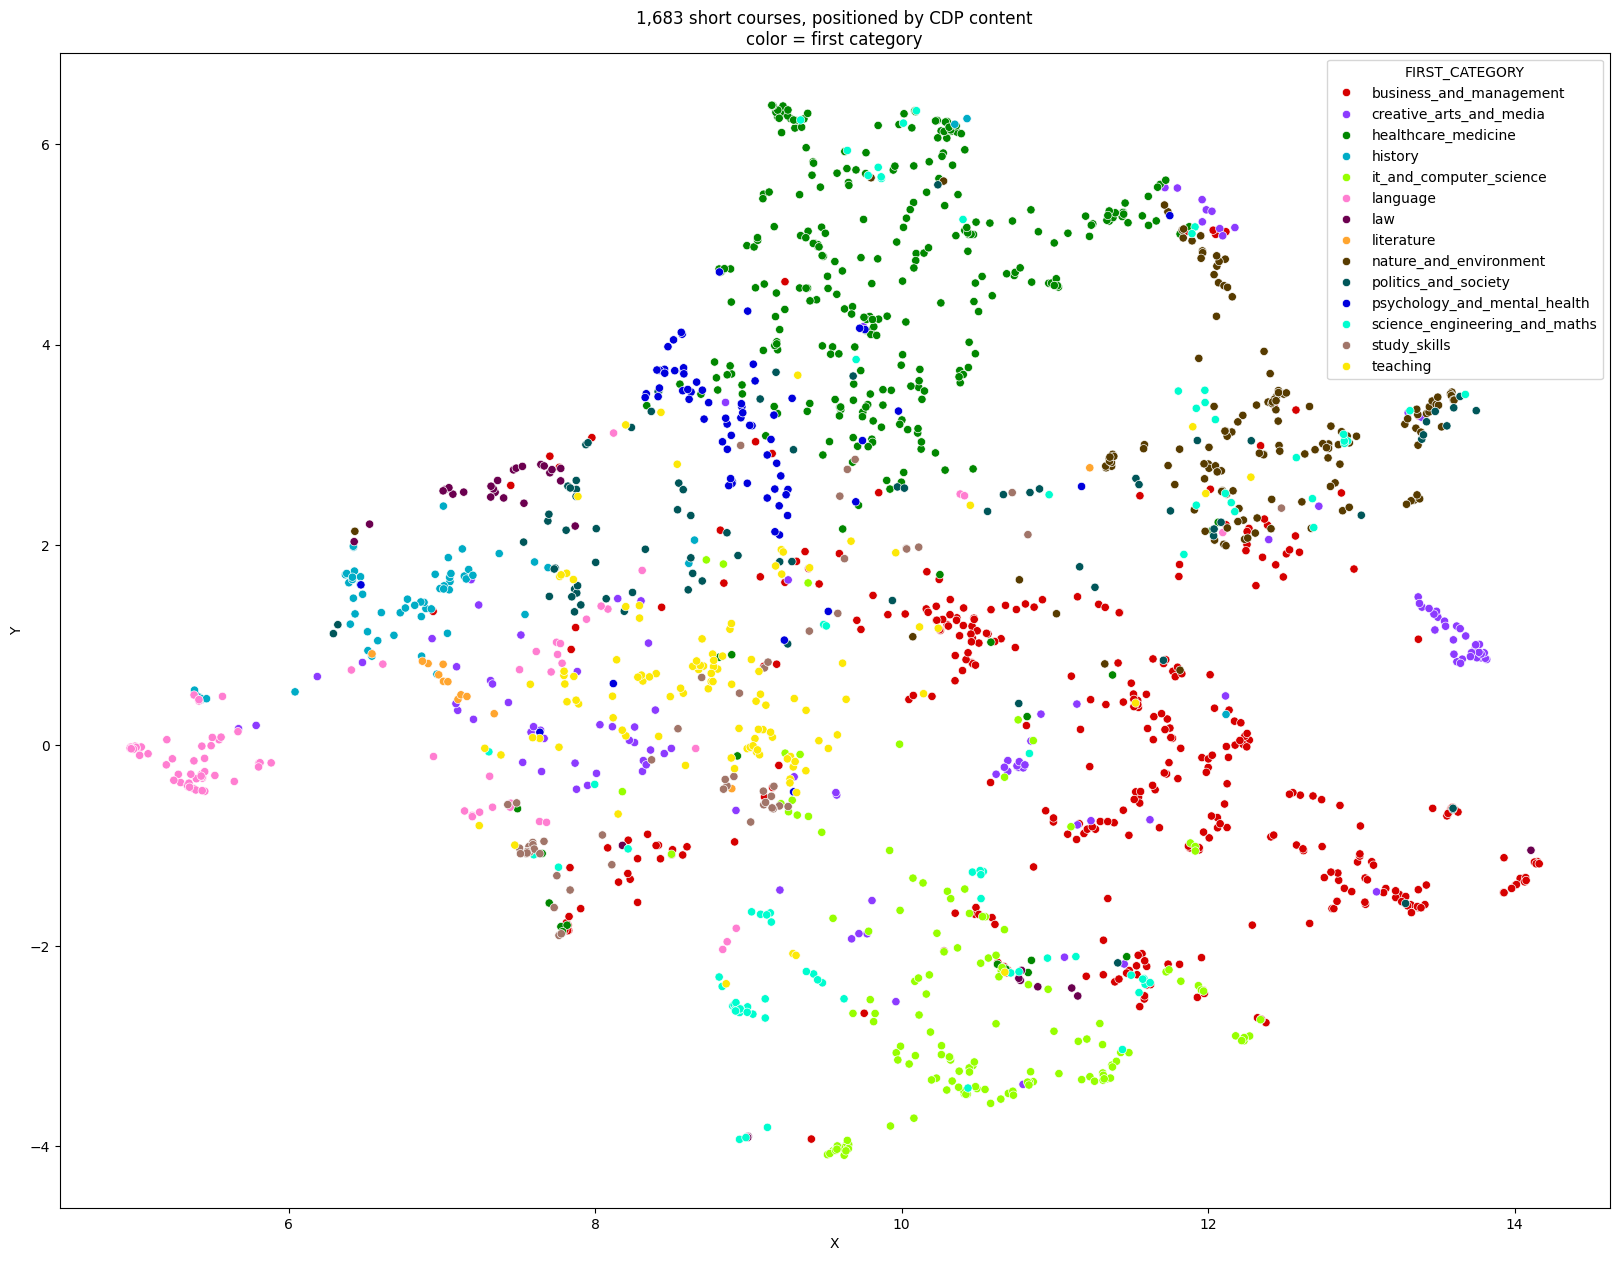

In [112]:
# let's plot
# NOTE: check ranges, if these should have been updated!

palette = ['#d60000','#8c3bff','#018700','#00acc6','#97ff00','#ff7ed1','#6b004f','#ffa52f','#573b00','#005659','#0000dd','#00fdcf','#a17569','#fce807']
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
g = sns.scatterplot(data=result_df,
                x="X",
                y="Y",
                hue="FIRST_CATEGORY",
                ax = ax,
                palette=palette)
ax.set_title('{:,}'.format(len(df))+" short courses, positioned by CDP content\ncolor = first category")
ax.set_xlabel("X")
ax.set_ylabel("Y")
#g.set(xlim=(4.5,14.5),ylim=(-1.5,9))

# X: [4.5,14.5]
# Y: [-1.5,9]

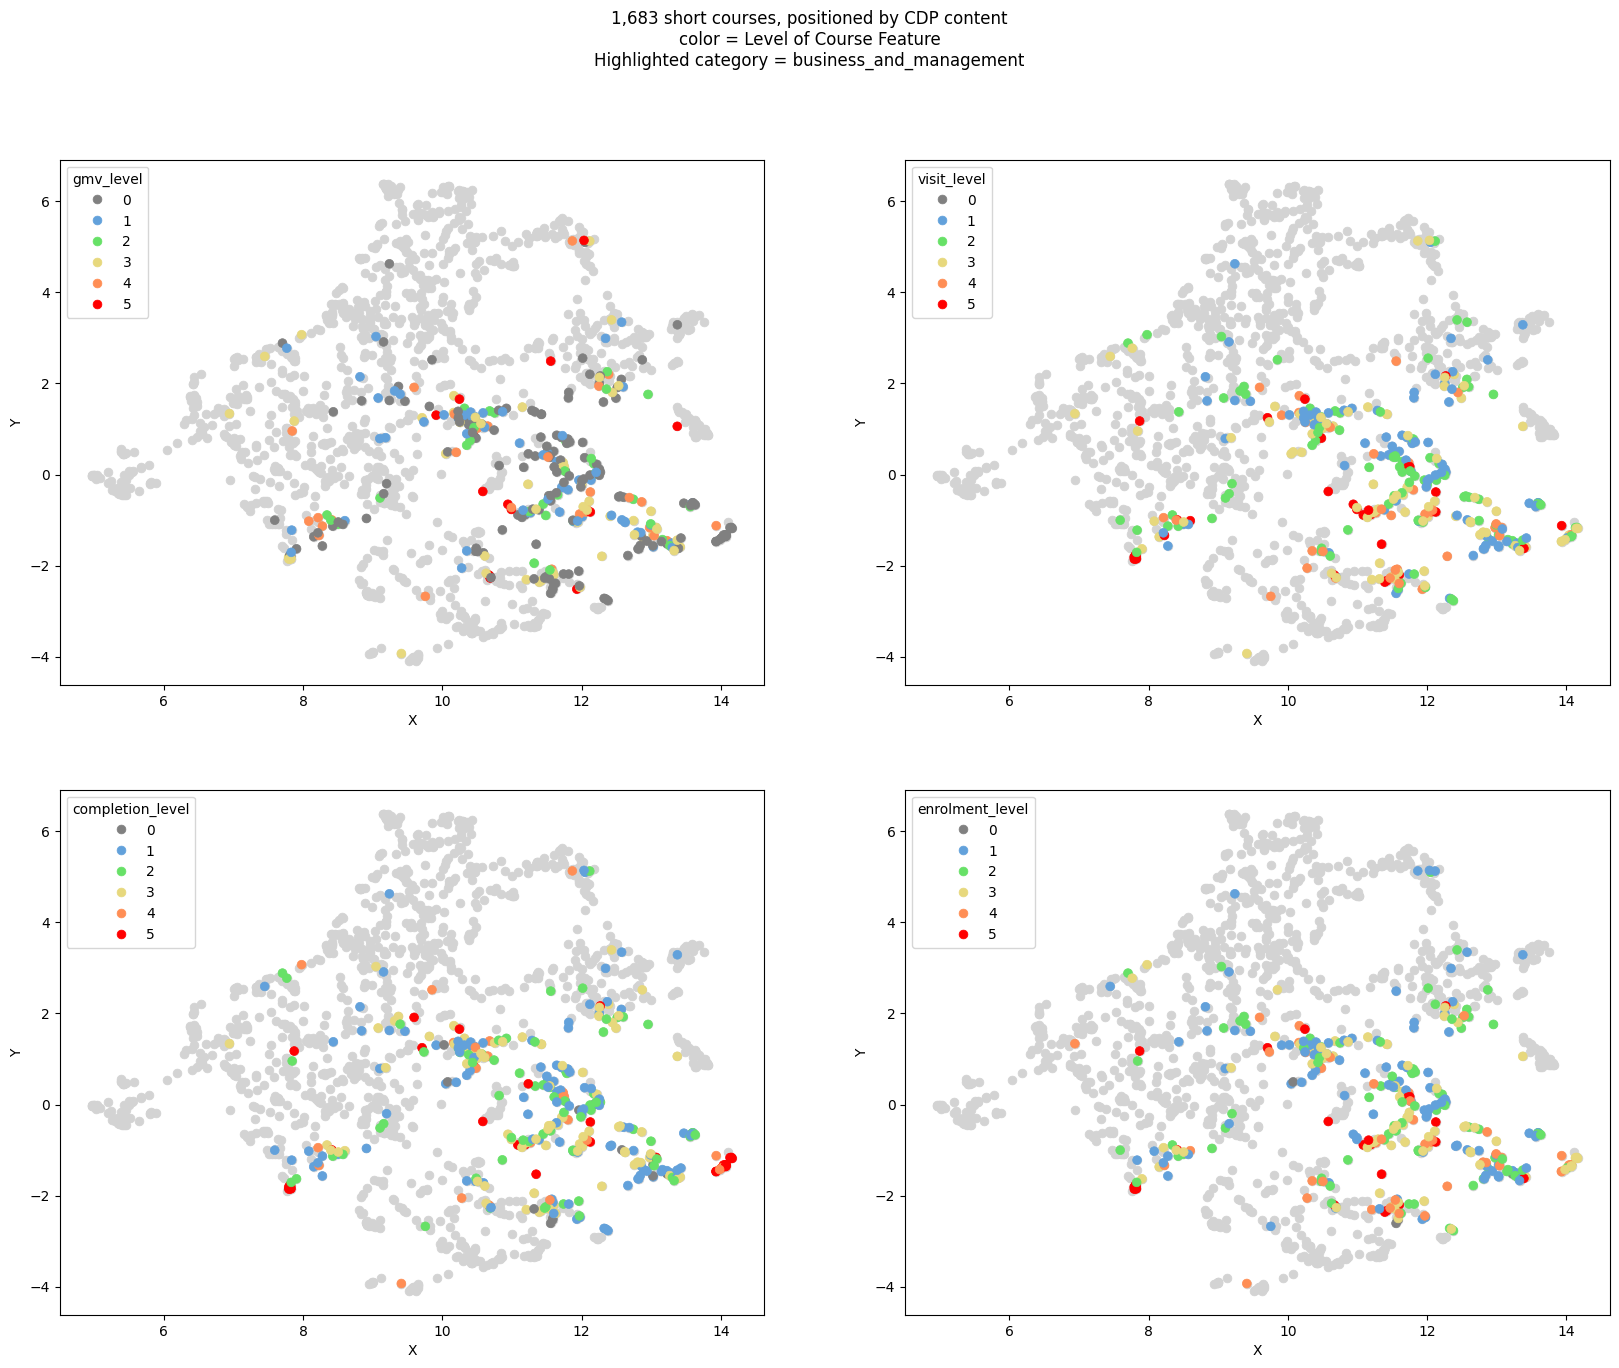

In [288]:
# NOTE: check ranges, if these should have been updated!
# plot only specific categories, while keeping the others grey surround and empty inside
categories = ['business_and_management','creative_arts_and_media','healthcare_medicine','history','it_and_computer_science','language',
              'law','literature','nature_and_environment','politics_and_society','psychology_and_mental_health',
              'science_engineering_and_maths','study_skills','teaching']
cat_to_highlight = 'business_and_management' # change this
cat_pos_to_highlight = categories.index(cat_to_highlight) # range [0-14]

palette_orig = ['grey','#62a1db','#67E167','#e7d87d','#FF8E55','#FF0000']
palette_grey = ['#e0e0e0']
palette = palette_grey

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('{:,}'.format(len(result_df))+" short courses, positioned by CDP content\ncolor = Level of Course Feature\nHighlighted category = "+cat_to_highlight)

g2 = sns.scatterplot(data=result_df,
                x="X",
                y="Y",
                ax = ax1,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                c='lightgrey',
                s=40)
g = sns.scatterplot(data=result_df[result_df.FIRST_CATEGORY == cat_to_highlight],
                x="X",
                y="Y",
                hue="gmv_level",
                ax = ax1,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                palette=palette_orig,
                s=40)

h2 = sns.scatterplot(data=result_df,
                x="X",
                y="Y",
                ax = ax2,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                c='lightgrey',
                s=40)
h = sns.scatterplot(data=result_df[result_df.FIRST_CATEGORY == cat_to_highlight],
                x="X",
                y="Y",
                hue="visit_level",
                ax = ax2,
                palette=palette_orig,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                s=40)

i2 = sns.scatterplot(data=result_df,
                x="X",
                y="Y",
                ax = ax3,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                c='lightgrey',
                s=40)
i = sns.scatterplot(data=result_df[result_df.FIRST_CATEGORY == cat_to_highlight],
                x="X",
                y="Y",
                hue="completion_level",
                ax = ax3,
                palette=palette_orig,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                s=40)

j2 = sns.scatterplot(data=result_df,
                x="X",
                y="Y",
                ax = ax4,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                c='lightgrey',
                s=40)
j = sns.scatterplot(data=result_df[result_df.FIRST_CATEGORY == cat_to_highlight],
                x="X",
                y="Y",
                hue="enrolment_level",
                ax = ax4,
                palette=palette_orig,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                s=40)


In [134]:
result_df[result_df.FIRST_CATEGORY == 'business_and_management']

COURSE_SLUG  \
402     project-management-principles-practices-systems   
271                sustainable-construction-development   
1422     introduction-to-big-data-analytics-with-hadoop   
1423                        hadoop-ecosystem-essentials   
1428  a-beginners-guide-to-data-handling-and-managem...   
...                                                 ...   
683                     the-human-face-of-user-research   
1564                      energised-and-empowered-teams   
1565              innovative-teams-with-design-thinking   
680                     career-planning-and-your-degree   
1566                            manage-team-performance   

                                            COURSE_NAME  \
402   Project Management Principles, Practices and S...   
271            Sustainable Construction and Development   
1422     Introduction to Big Data Analytics with Hadoop   
1423                        Hadoop Ecosystem Essentials   
1428  A Beginnerâs Guide to Data Handling and Mana...   
...                                                 ...   
683   The Human Face of User Research: How to do Use...   
1564               Create Energised and Empowered Teams   
1565       Create Innovative Teams with Design Thinking   
680   University and Your Future: Career Planning an...   
1566                            Manage Team Performance   

               FIRST_CATEGORY          SECOND_CATEGORY  \
402   business_and_management                     <NA>   
271   business_and_management   nature_and_environment   
1422  business_and_management                     <NA>   
1423  business_and_management  it_and_computer_science   
1428  business_and_management  it_and_computer_science   
...                       ...                      ...   
683   business_and_management  it_and_computer_science   
1564  business_and_management                     <NA>   
1565  business_and_management                     <NA>   
680   business_and_management             study_skills   
1566  business_and_management                     <NA>   

                                           TOPICS_ARRAY  \
402                                [Project Management]   
271                      [Construction, Sustainability]   
1422  [Data Visualisation, Decision-making, Data Ana...   
1423  [Data Analysis, Data Analytics, Big Data & Ana...   
1428  [Excel, Data Analysis, Big Data & Analytics, B...   
...                                                 ...   
683   [Project Management, Business Technology, Data...   
1564                          [Management & Leadership]   
1565                          [Management & Leadership]   
680                                                [na]   
1566                          [Management & Leadership]   

                                    CATEGORIES_ARRAY DIFFICULTY_LEVEL  \
402                          [Business & Management]     Introductory   
271    [Nature & Environment, Business & Management]     Introductory   
1422                         [Business & Management]     Introductory   
1423  [IT & Computer Science, Business & Management]     Introductory   
1428  [IT & Computer Science, Business & Management]     Introductory   
...                                              ...              ...   
683   [IT & Computer Science, Business & Management]     Introductory   
1564                         [Business & Management]     Introductory   
1565                         [Business & Management]     Introductory   
680            [Study Skills, Business & Management]     Introductory   
1566                         [Business & Management]     Introductory   

                               concatenated_cdp_content  \
402   Project Management Principles, Practices and S...   
271   Sustainable Construction and Development Help ...   
1422  Introduction to Big Data Analytics with Hadoop...   
1423  Hadoop Ecosystem Essentials Develop essential ...   
1428  A Beginnerâs Guide to Data Handling and 

In [133]:
# NOTE: check ranges, if these should have been updated!
# plot only specific categories, while keeping the others grey surround and empty inside
categories = ['business_and_management','creative_arts_and_media','healthcare_medicine','history','it_and_computer_science','language',
              'law','literature','nature_and_environment','politics_and_society','psychology_and_mental_health',
              'science_engineering_and_maths','study_skills','teaching']
cat_to_highlight = 'teaching' # change this
cat_pos_to_highlight = categories.index(cat_to_highlight) # range [0-14]



fig, ax = plt.subplots(1, 1, figsize=(20, 15))
g = sns.scatterplot(data=result_df,
                x="X",
                y="Y",
                hue="gmv_level",
                ax = ax,
                palette=palette,
                # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                ec="face",
                marker="$\circ$",
                s=70)

ax.set_title('{:,}'.format(len(df))+" short courses, positioned by CDP content\ncolor = first category\nHighlighted category = "+cat_to_highlight)
ax.set_xlabel("X")
ax.set_ylabel("Y")

# X: [4.5,14.5]
# Y: [-1.5,9]

<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7v/l62ckmdx3djccmgd9b2y6yf80000gn/T/ipykernel_30398/3530387528.py:23: SyntaxWarning: invalid escape sequence '\c'
  marker="$\circ$",
/var/folders/7v/l62ckmdx3djccmgd9b2y6yf80000gn/T/ipykernel_30398/3530387528.py:23: SyntaxWarning: invalid escape sequence '\c'
  marker="$\circ$",


IndexError: list index out of range

saved file cat_business_and_management
saved file cat_creative_arts_and_media
saved file cat_healthcare_medicine
saved file cat_history
saved file cat_it_and_computer_science
saved file cat_language
saved file cat_law
saved file cat_literature
saved file cat_nature_and_environment
saved file cat_politics_and_society
saved file cat_psychology_and_mental_health
saved file cat_science_engineering_and_maths
saved file cat_study_skills
saved file cat_teaching


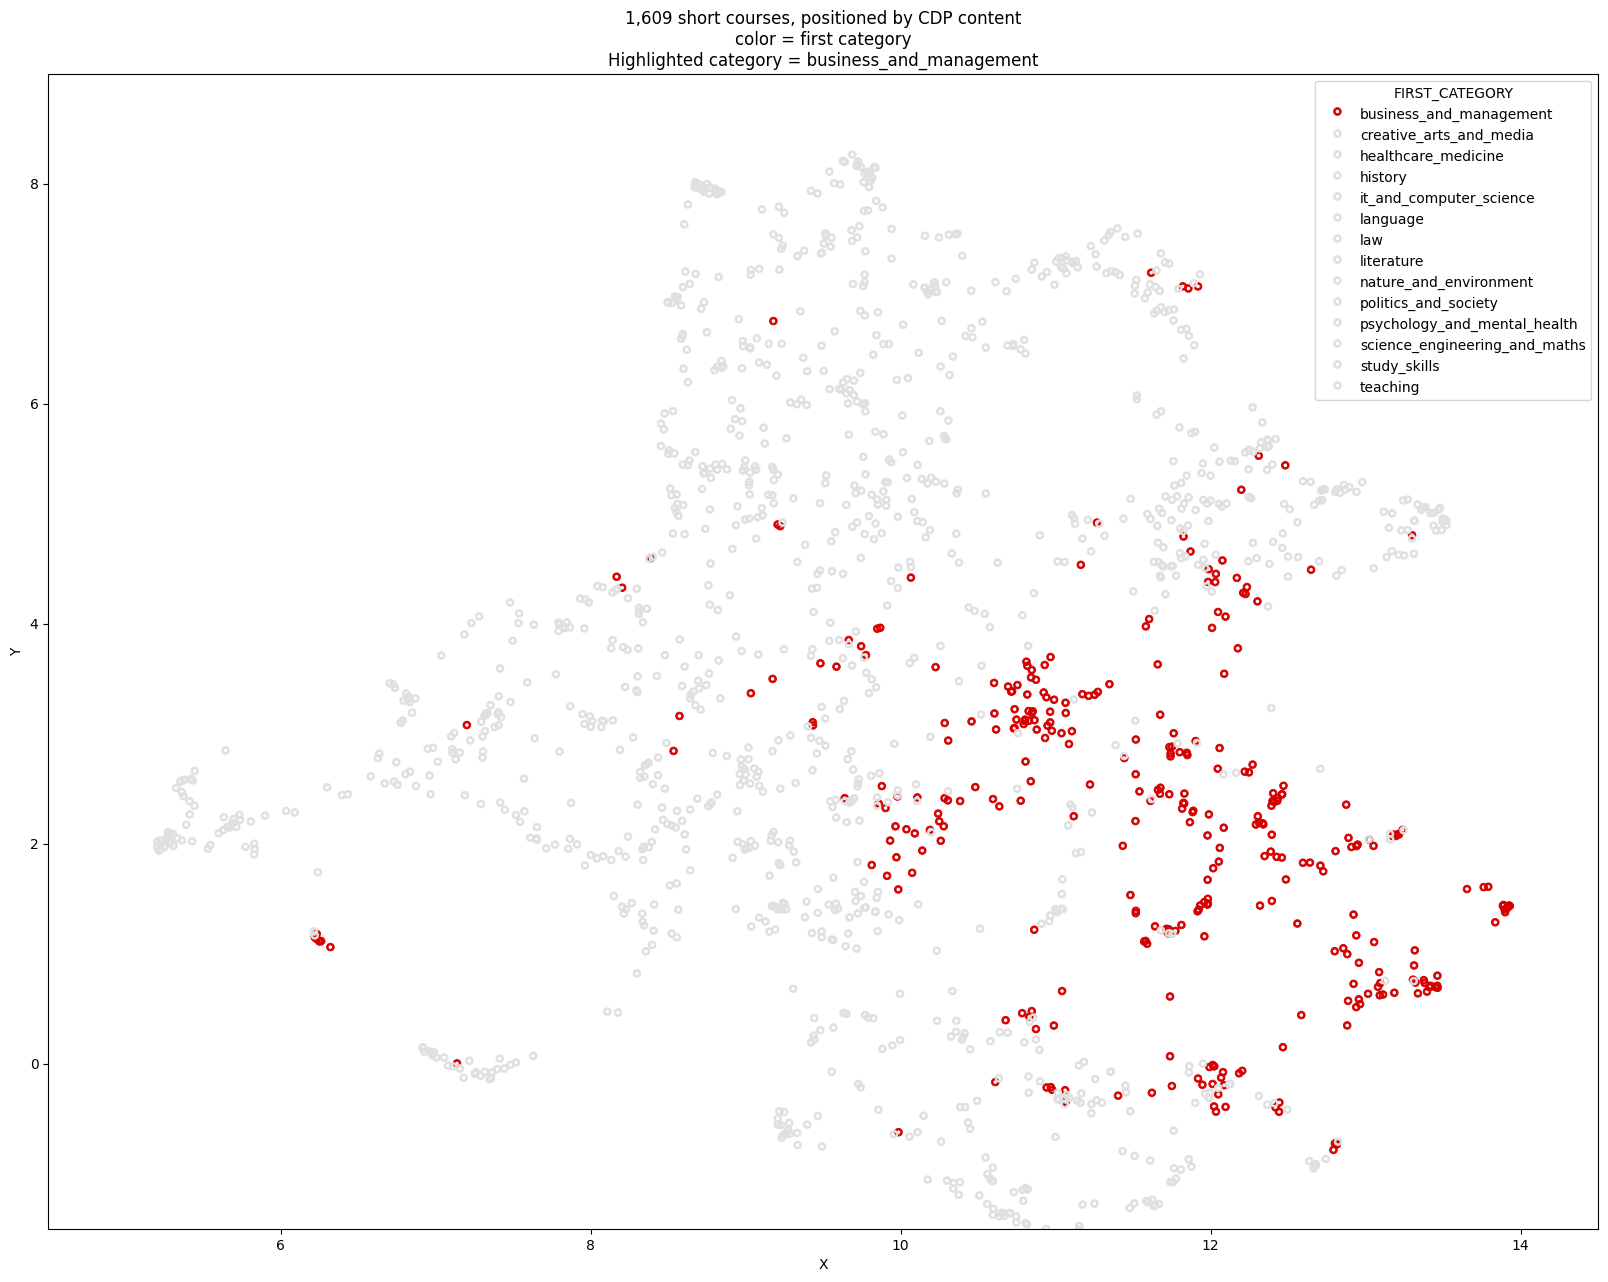

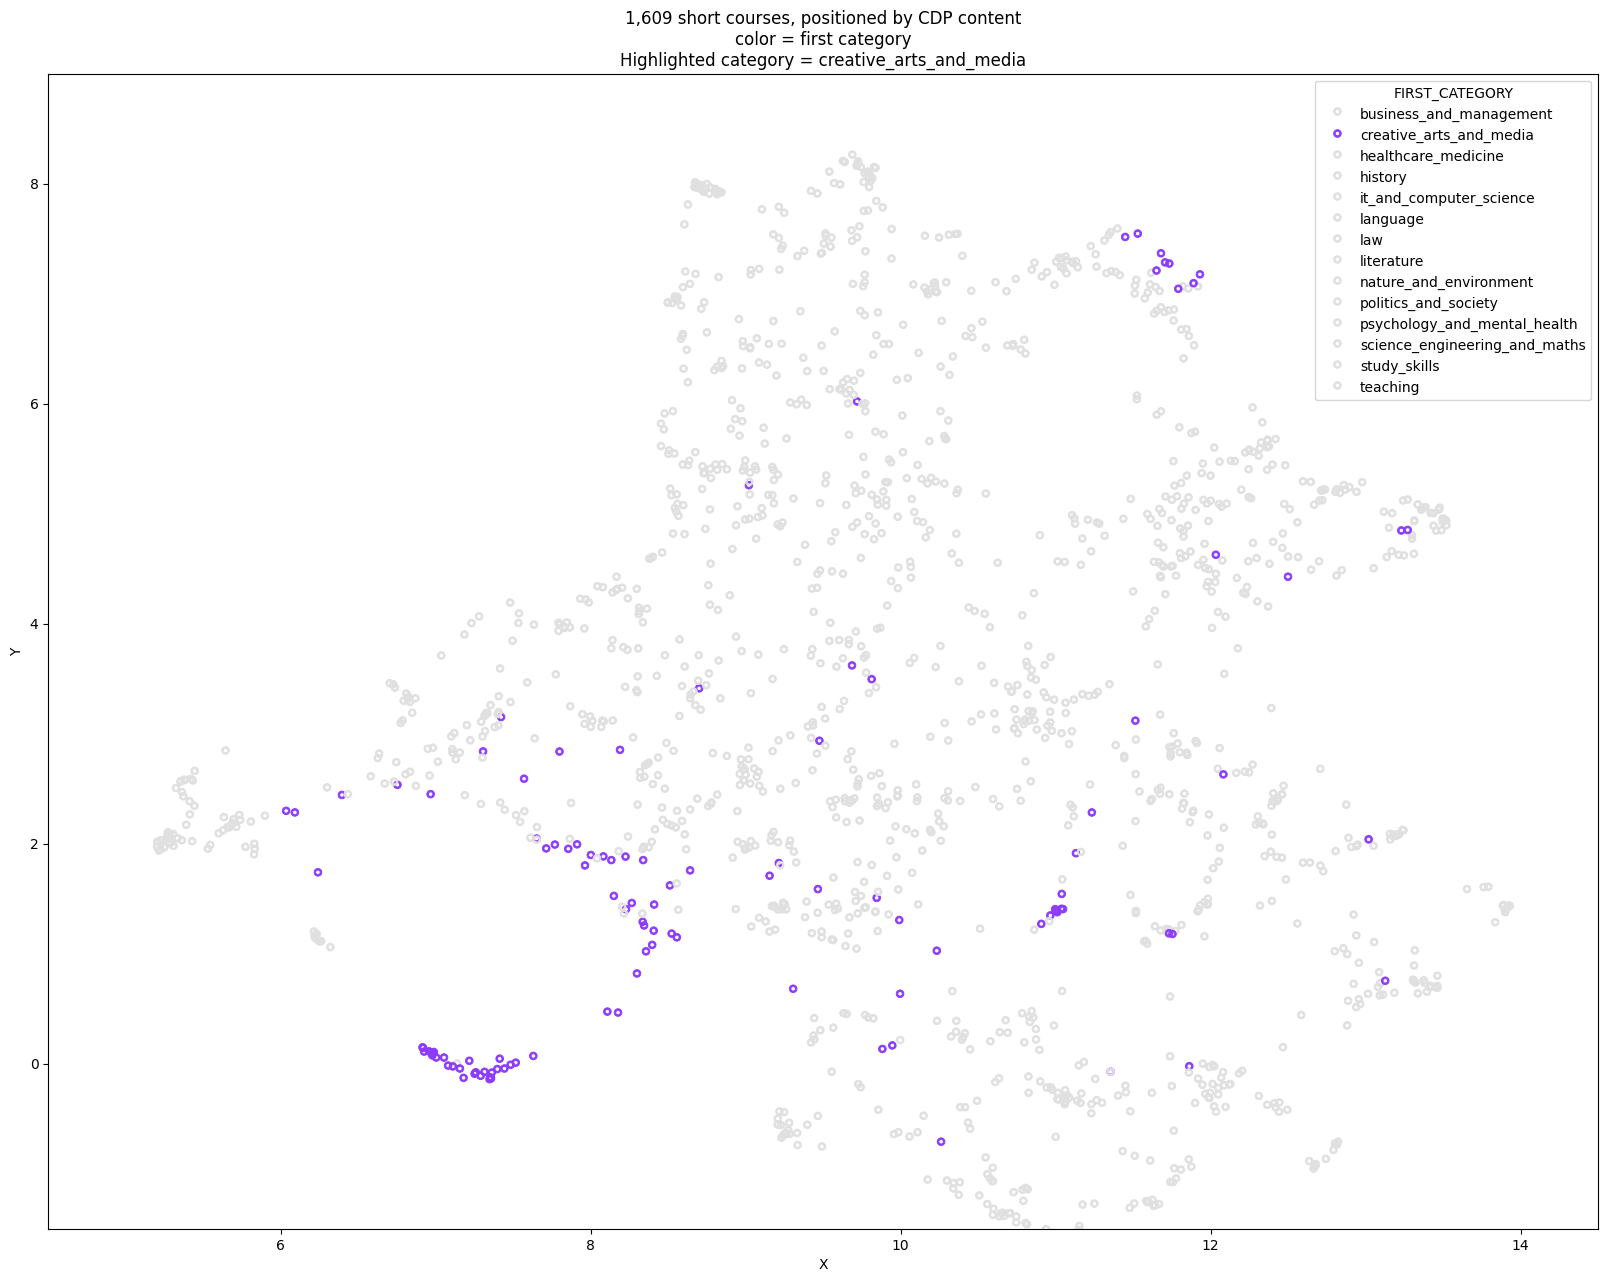

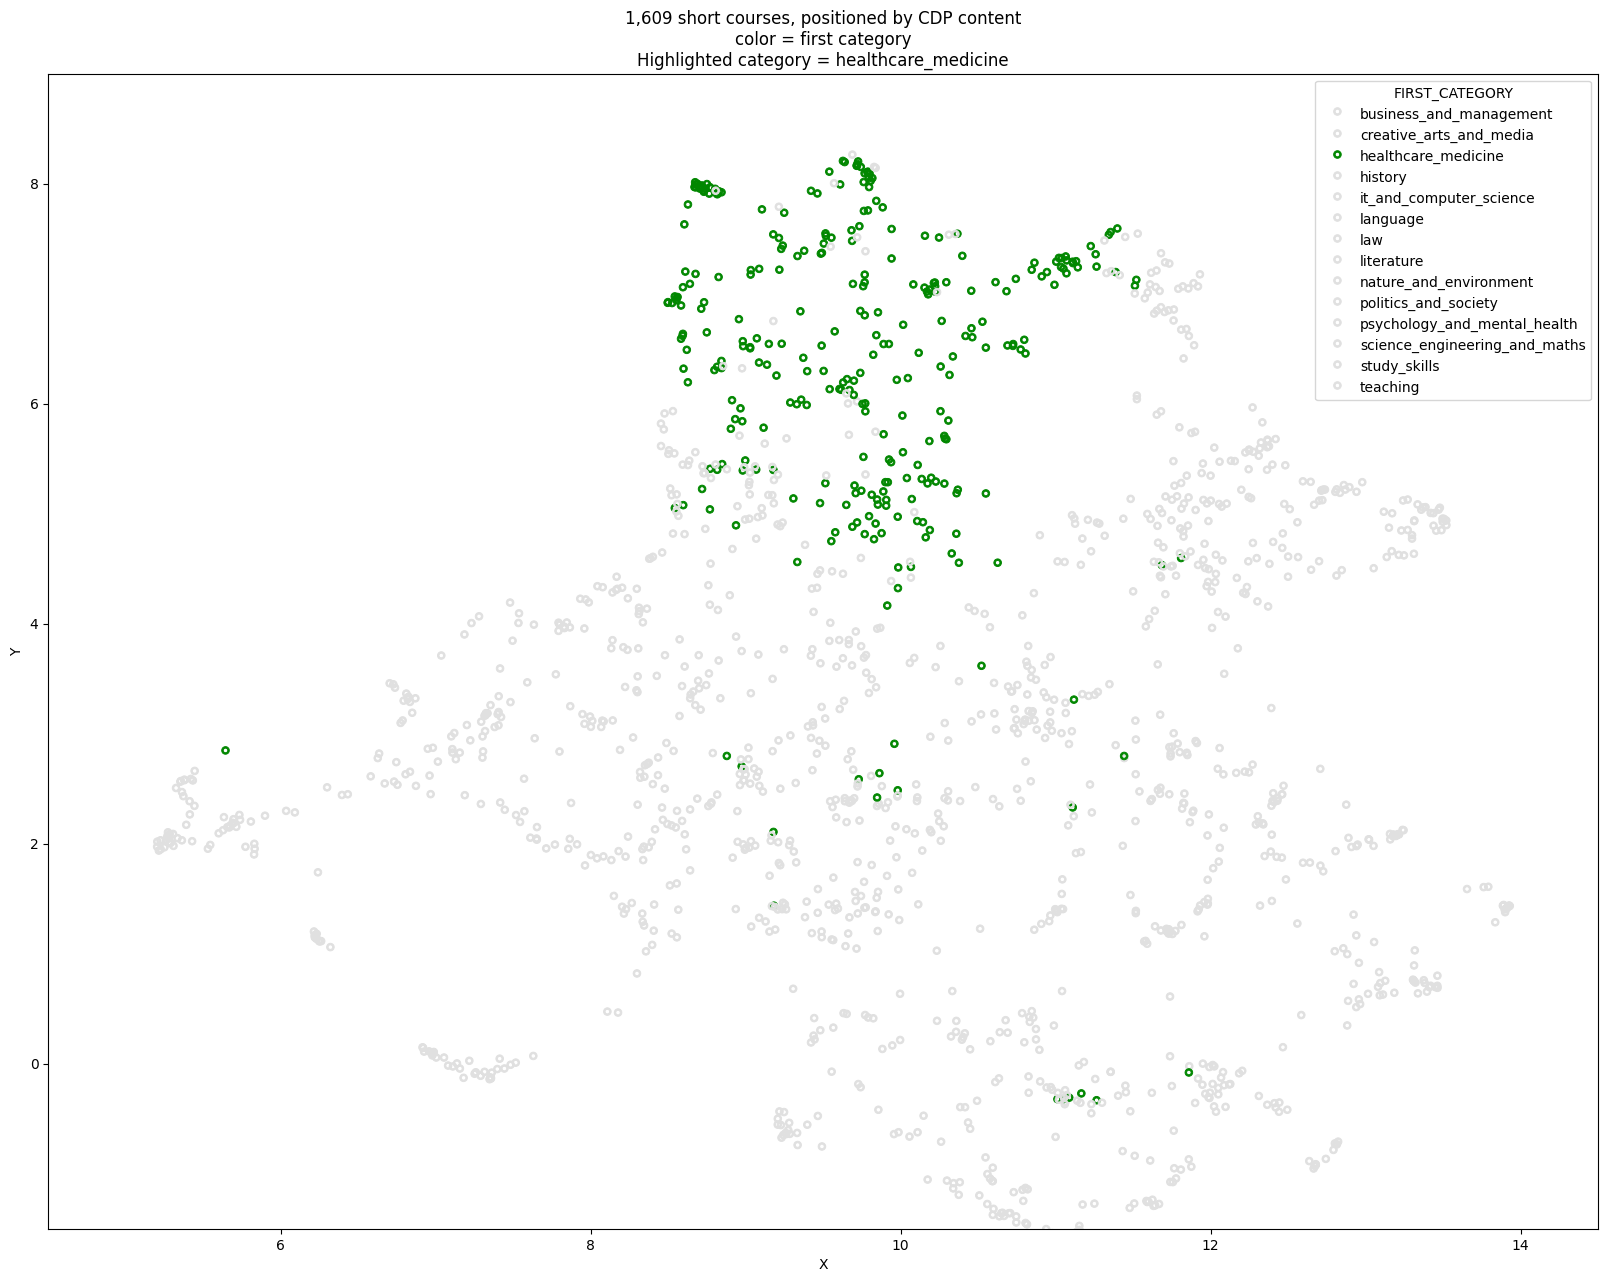

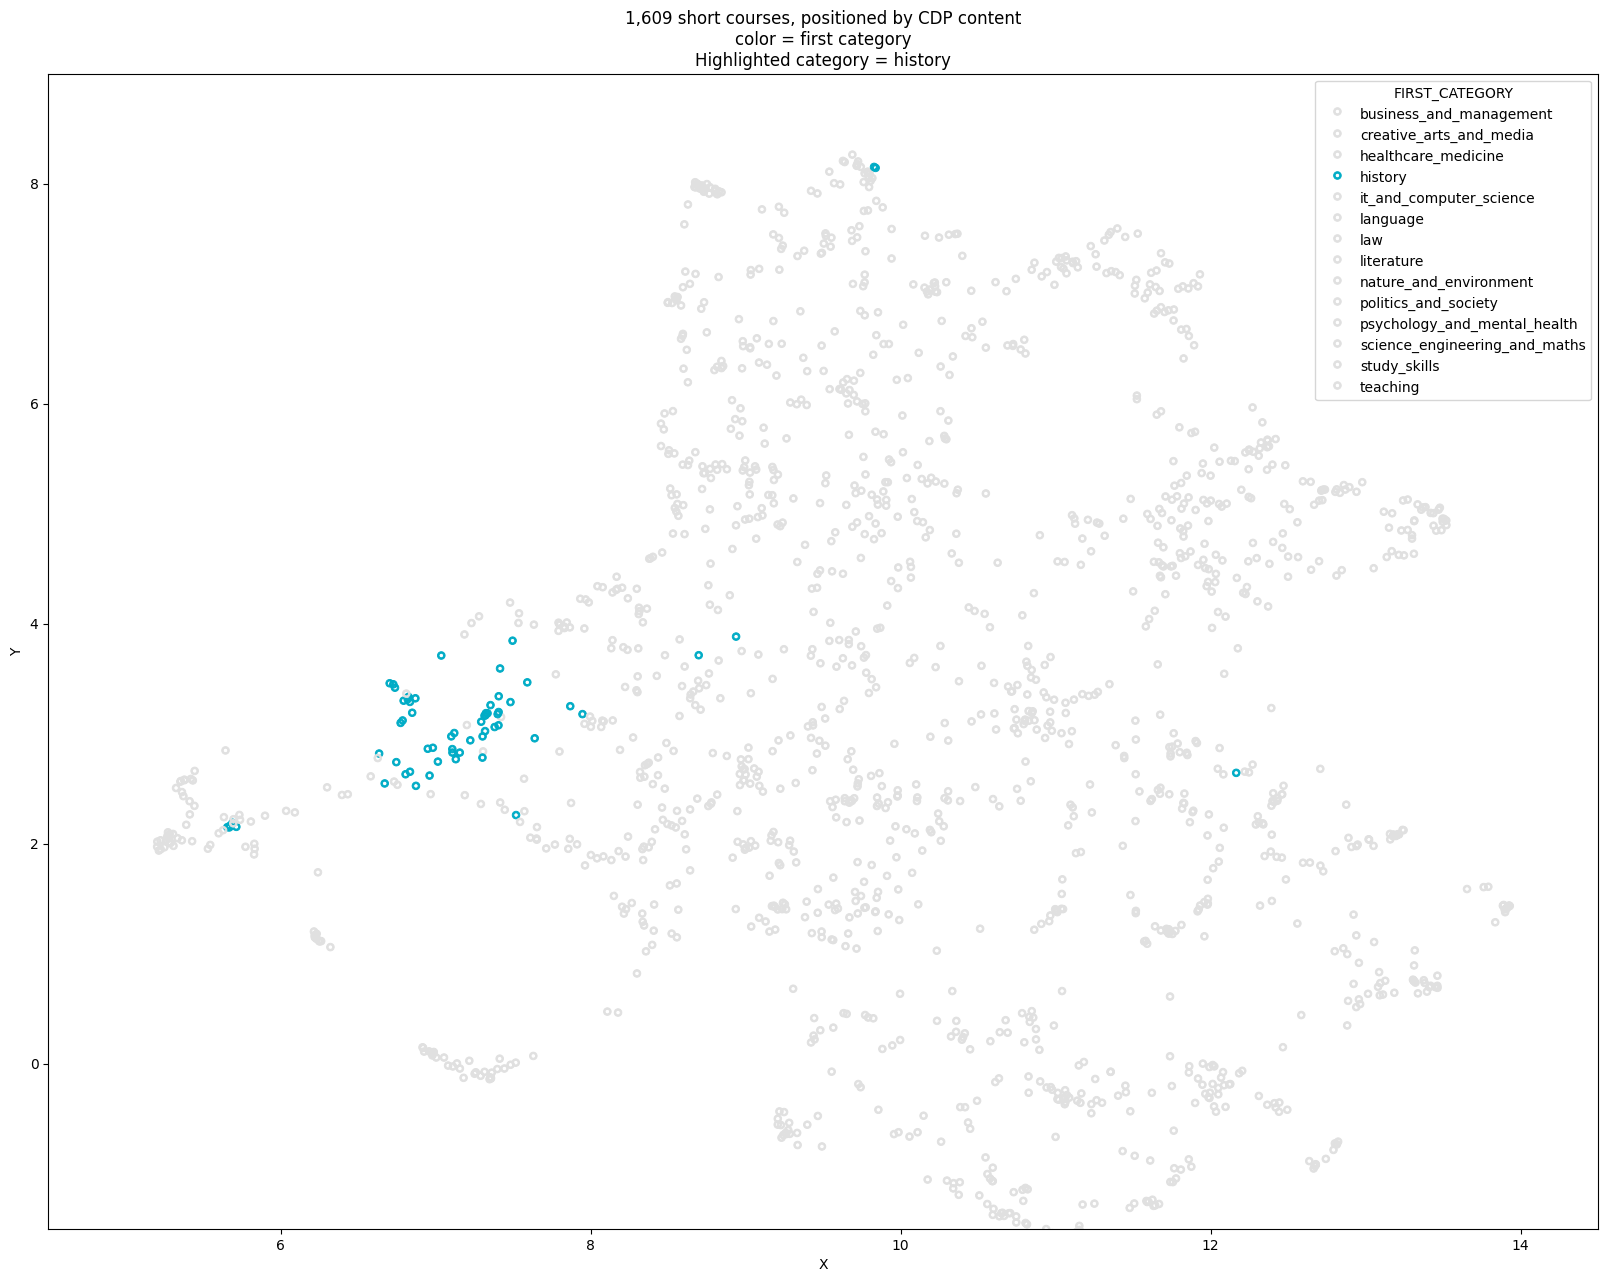

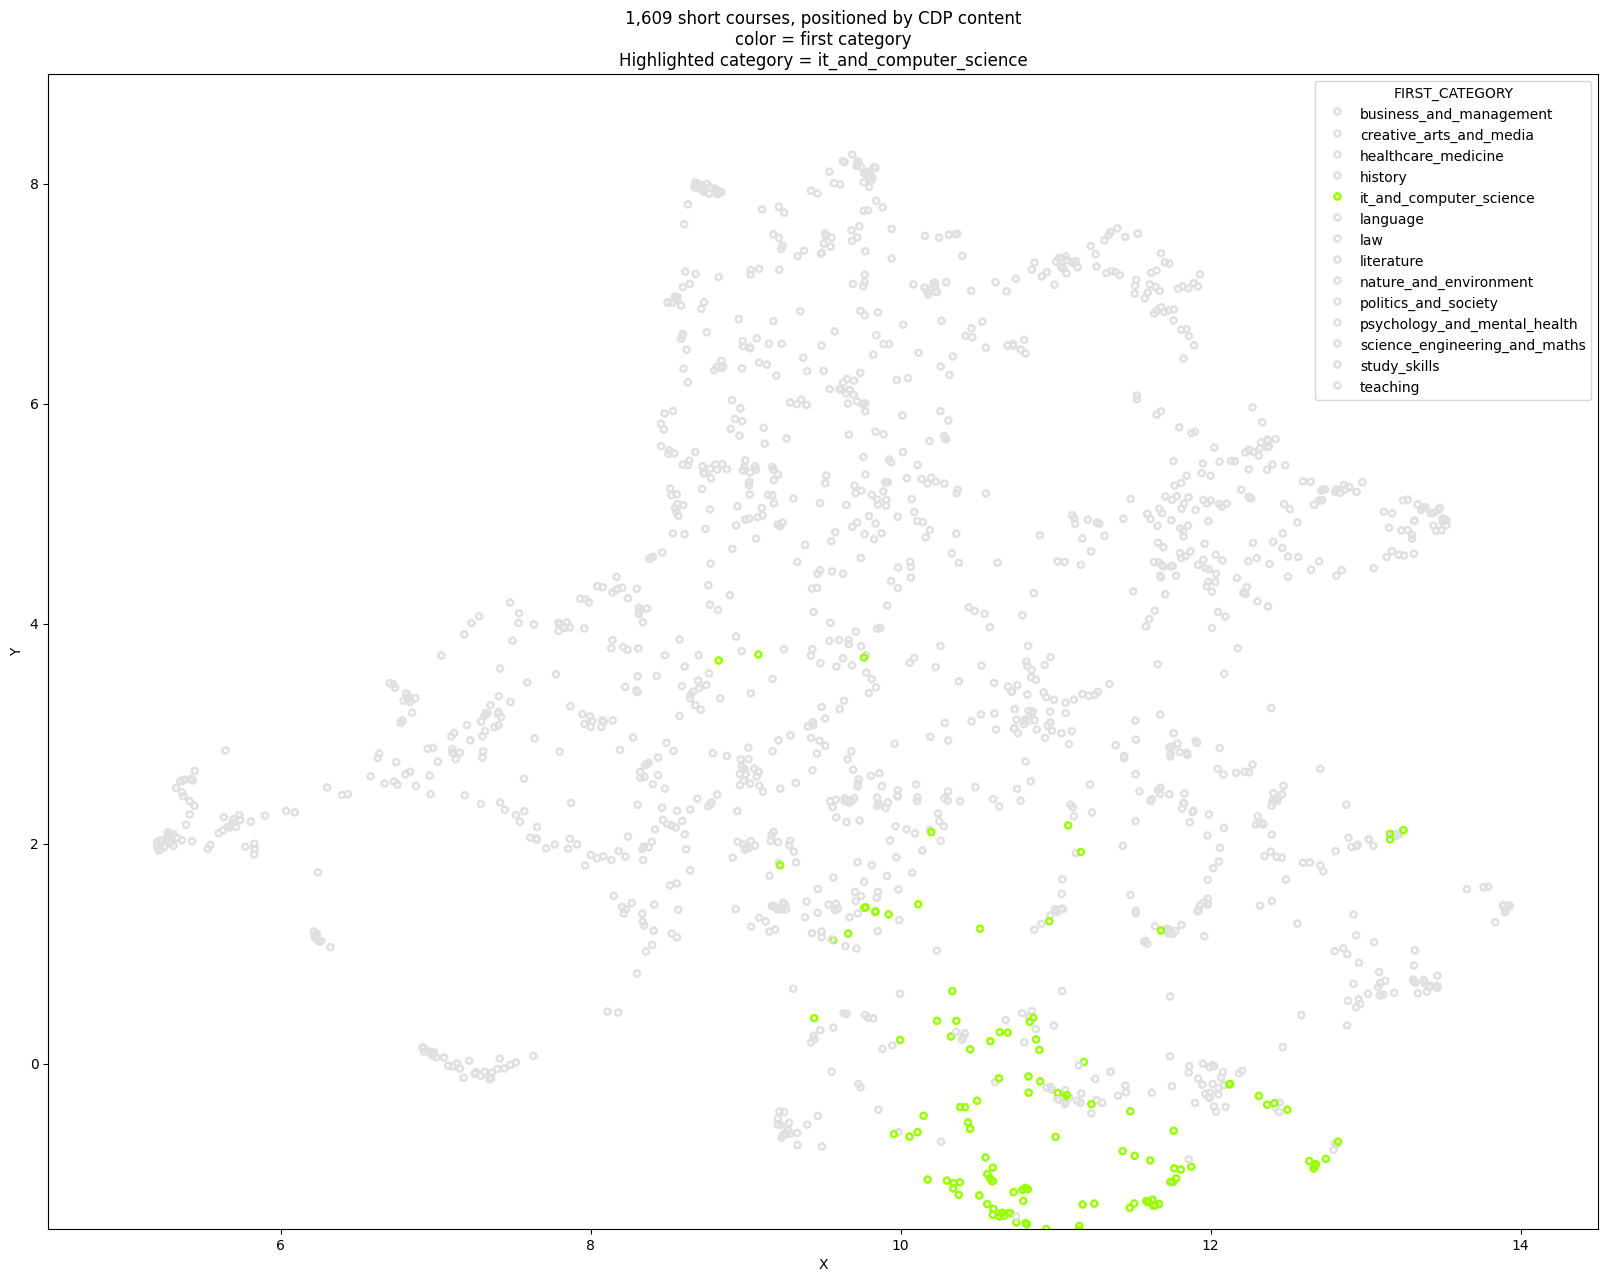

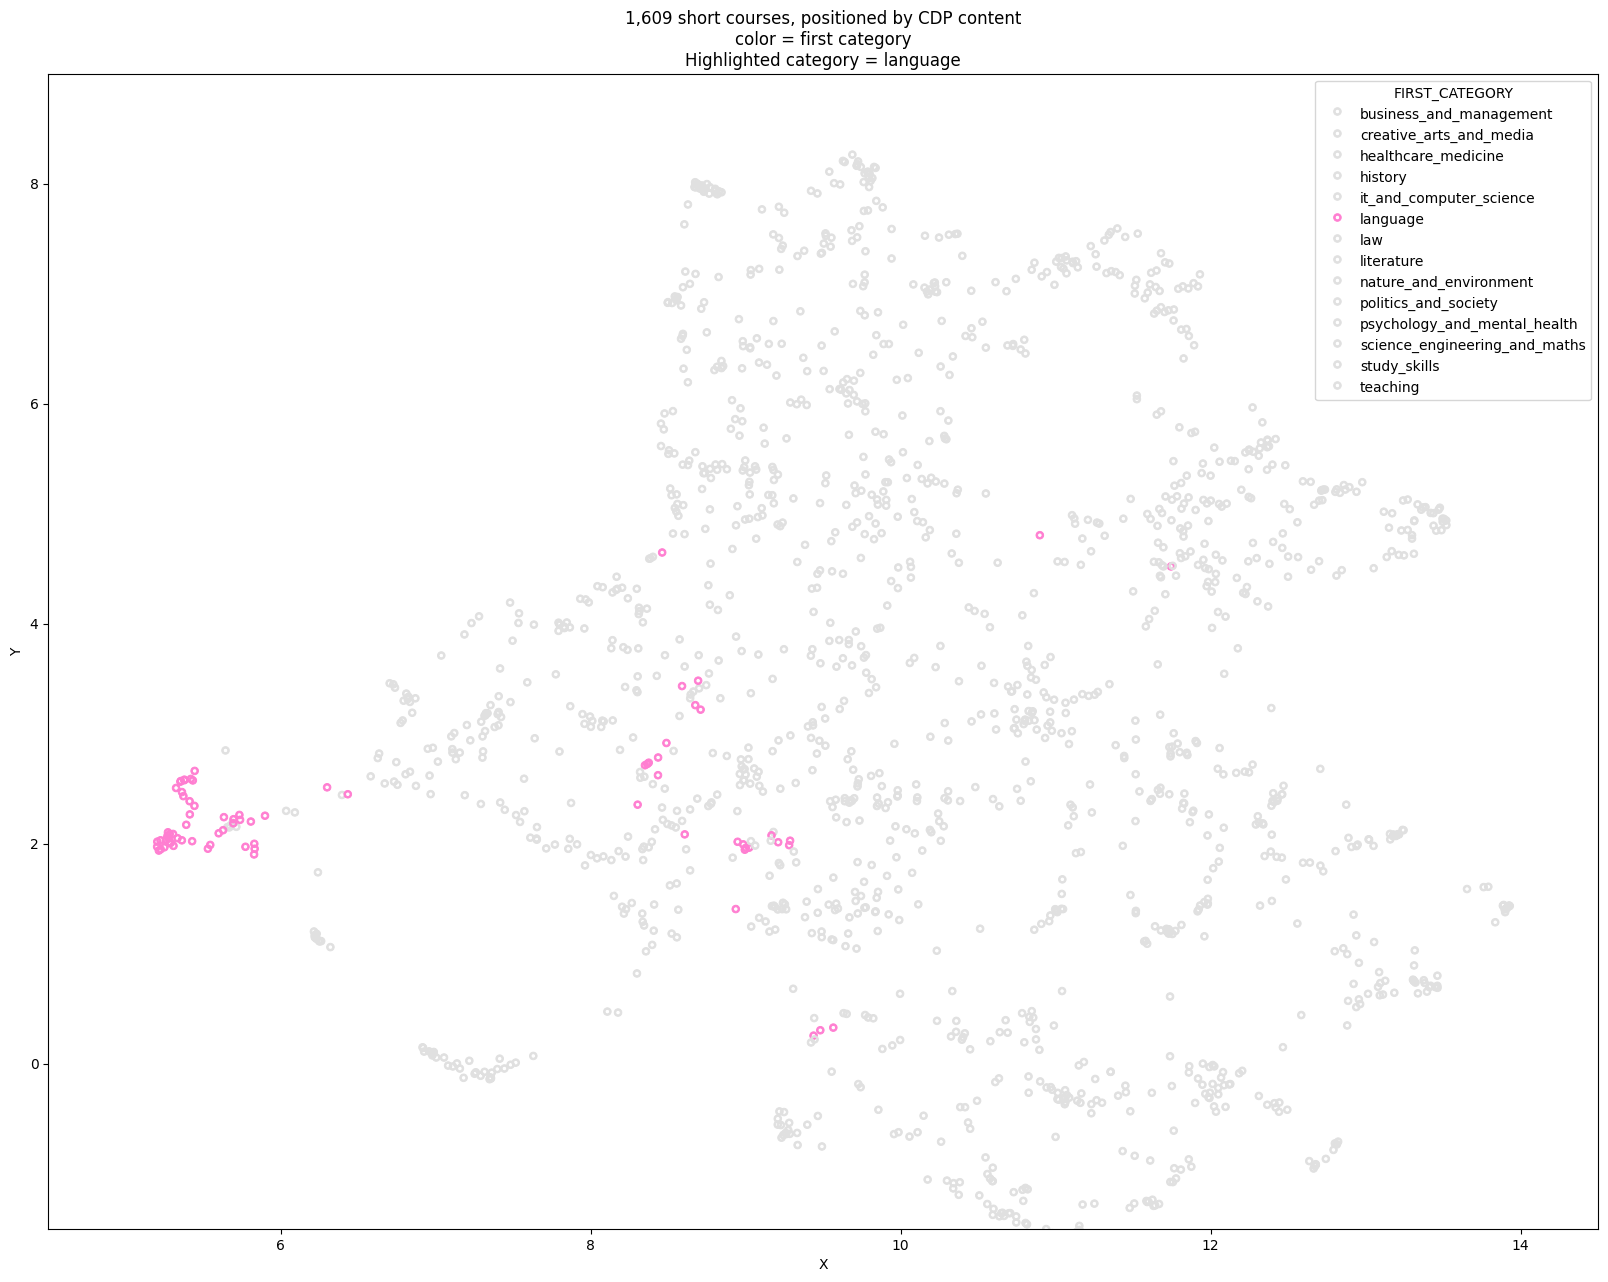

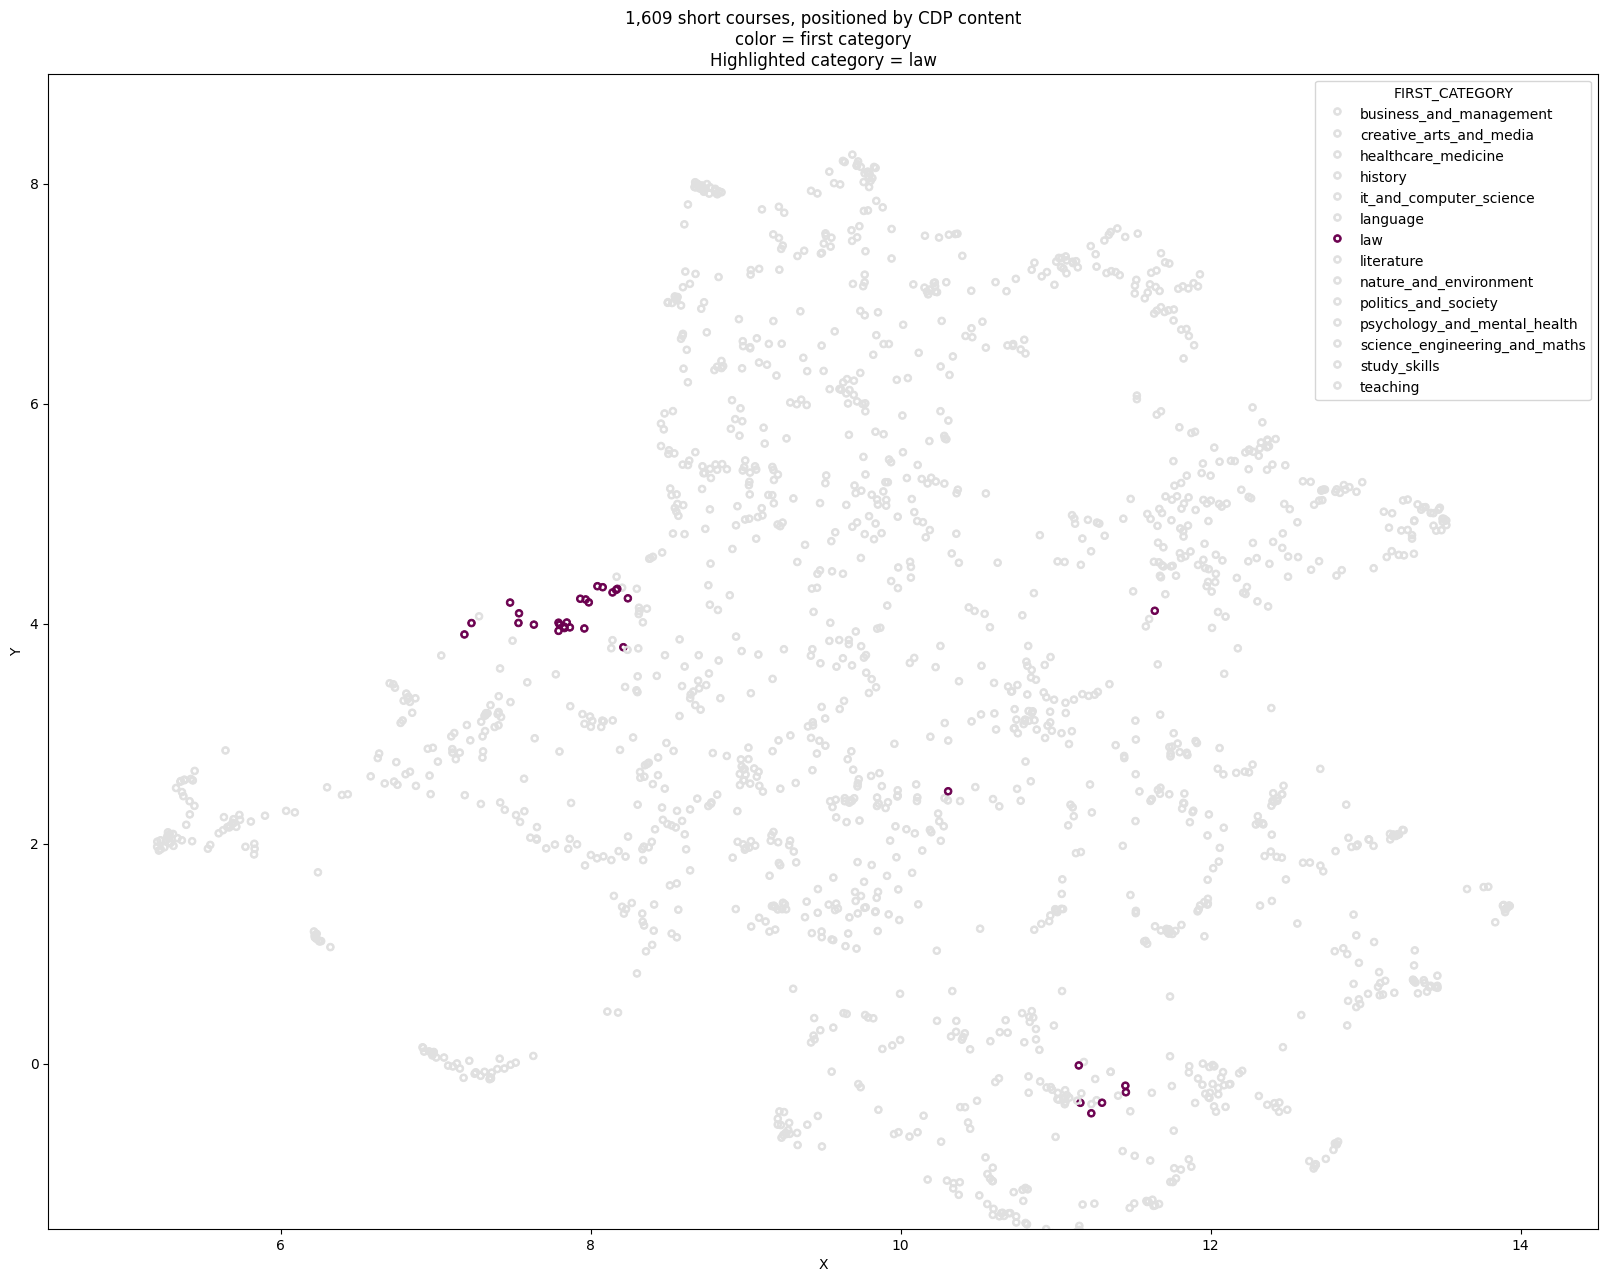

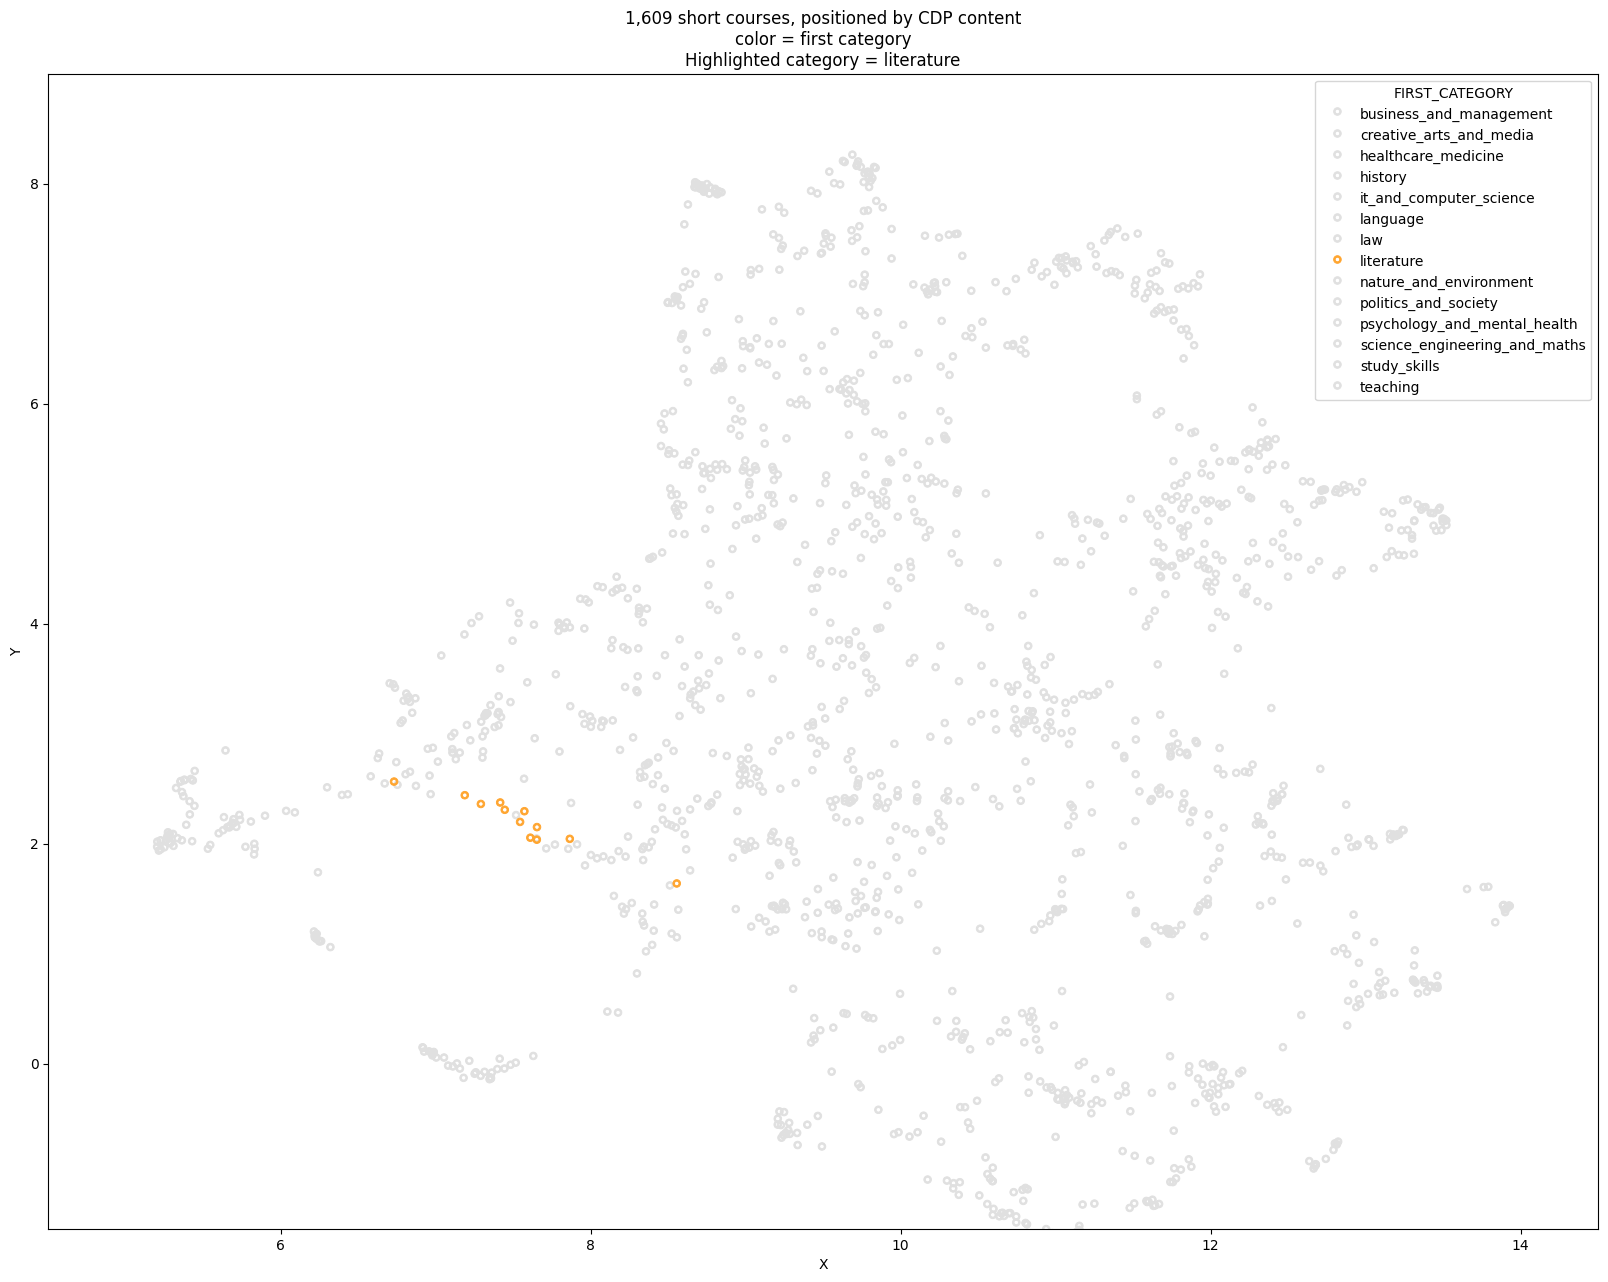

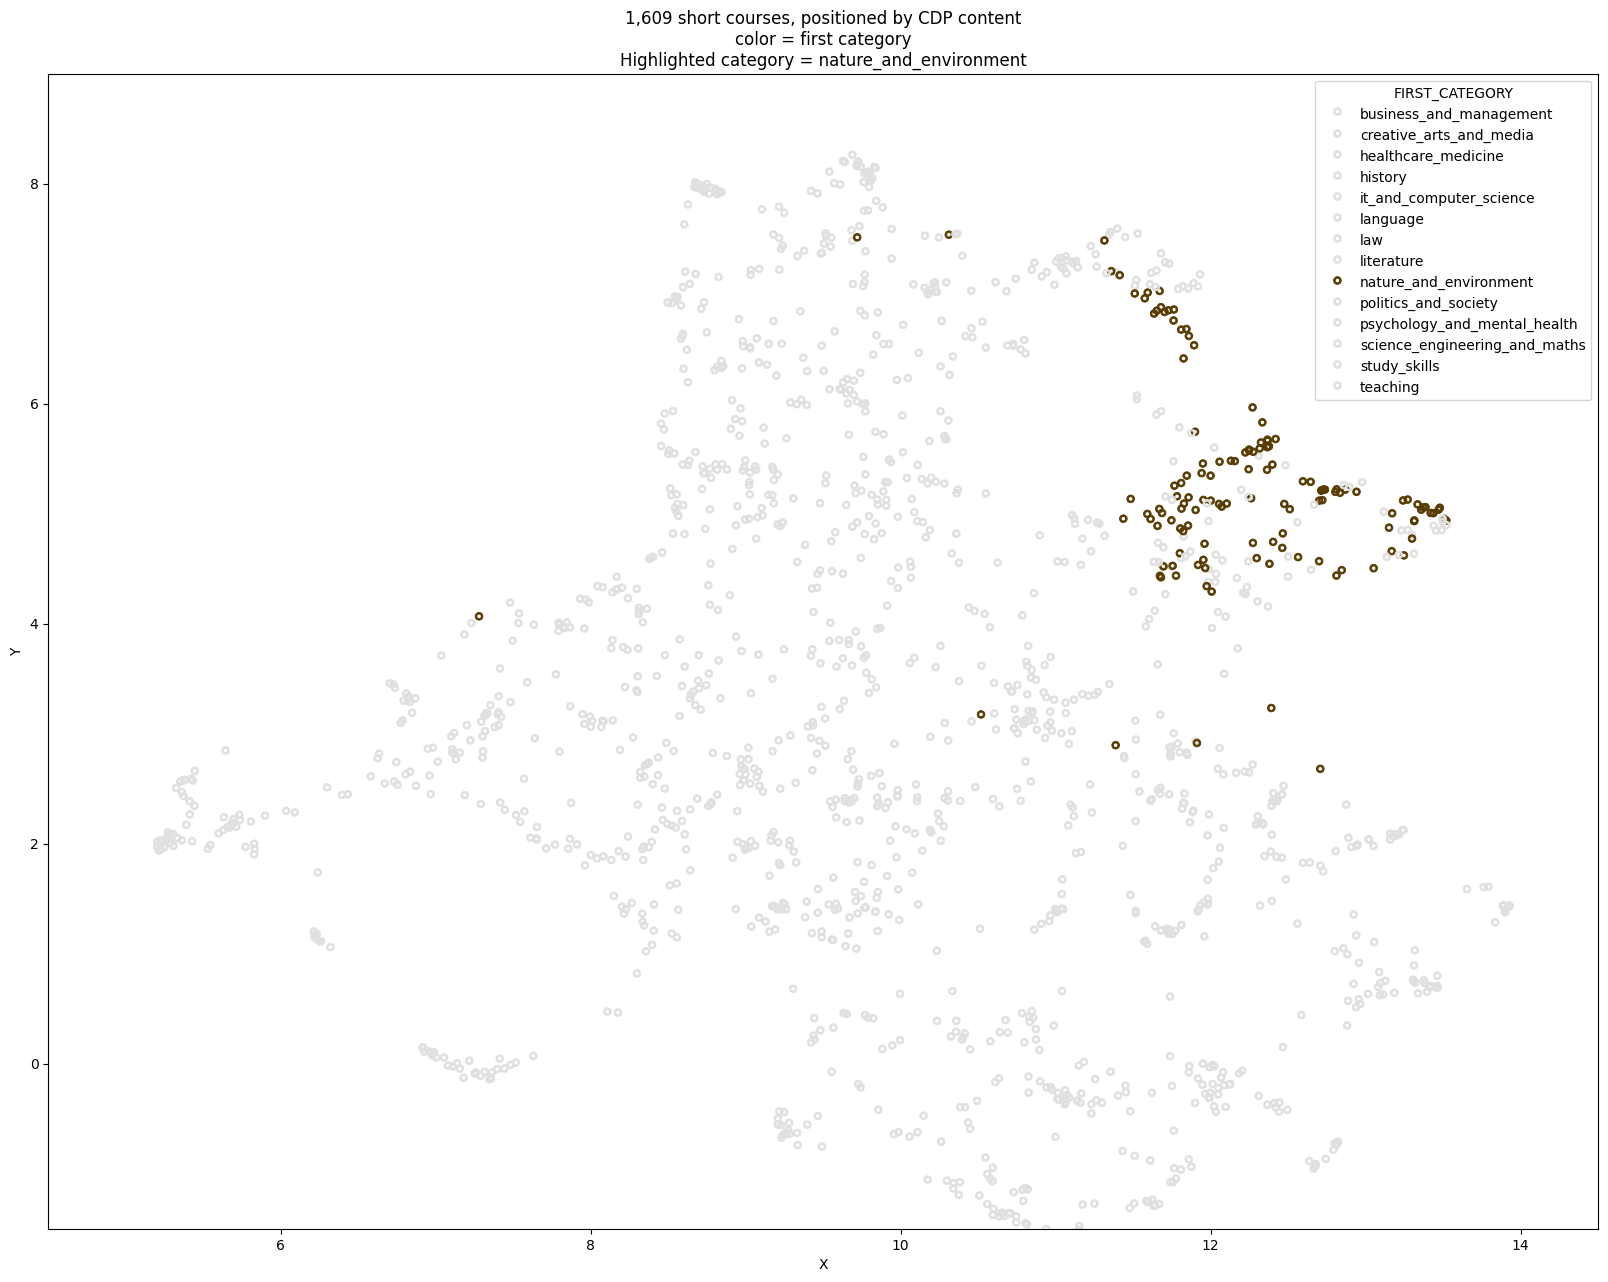

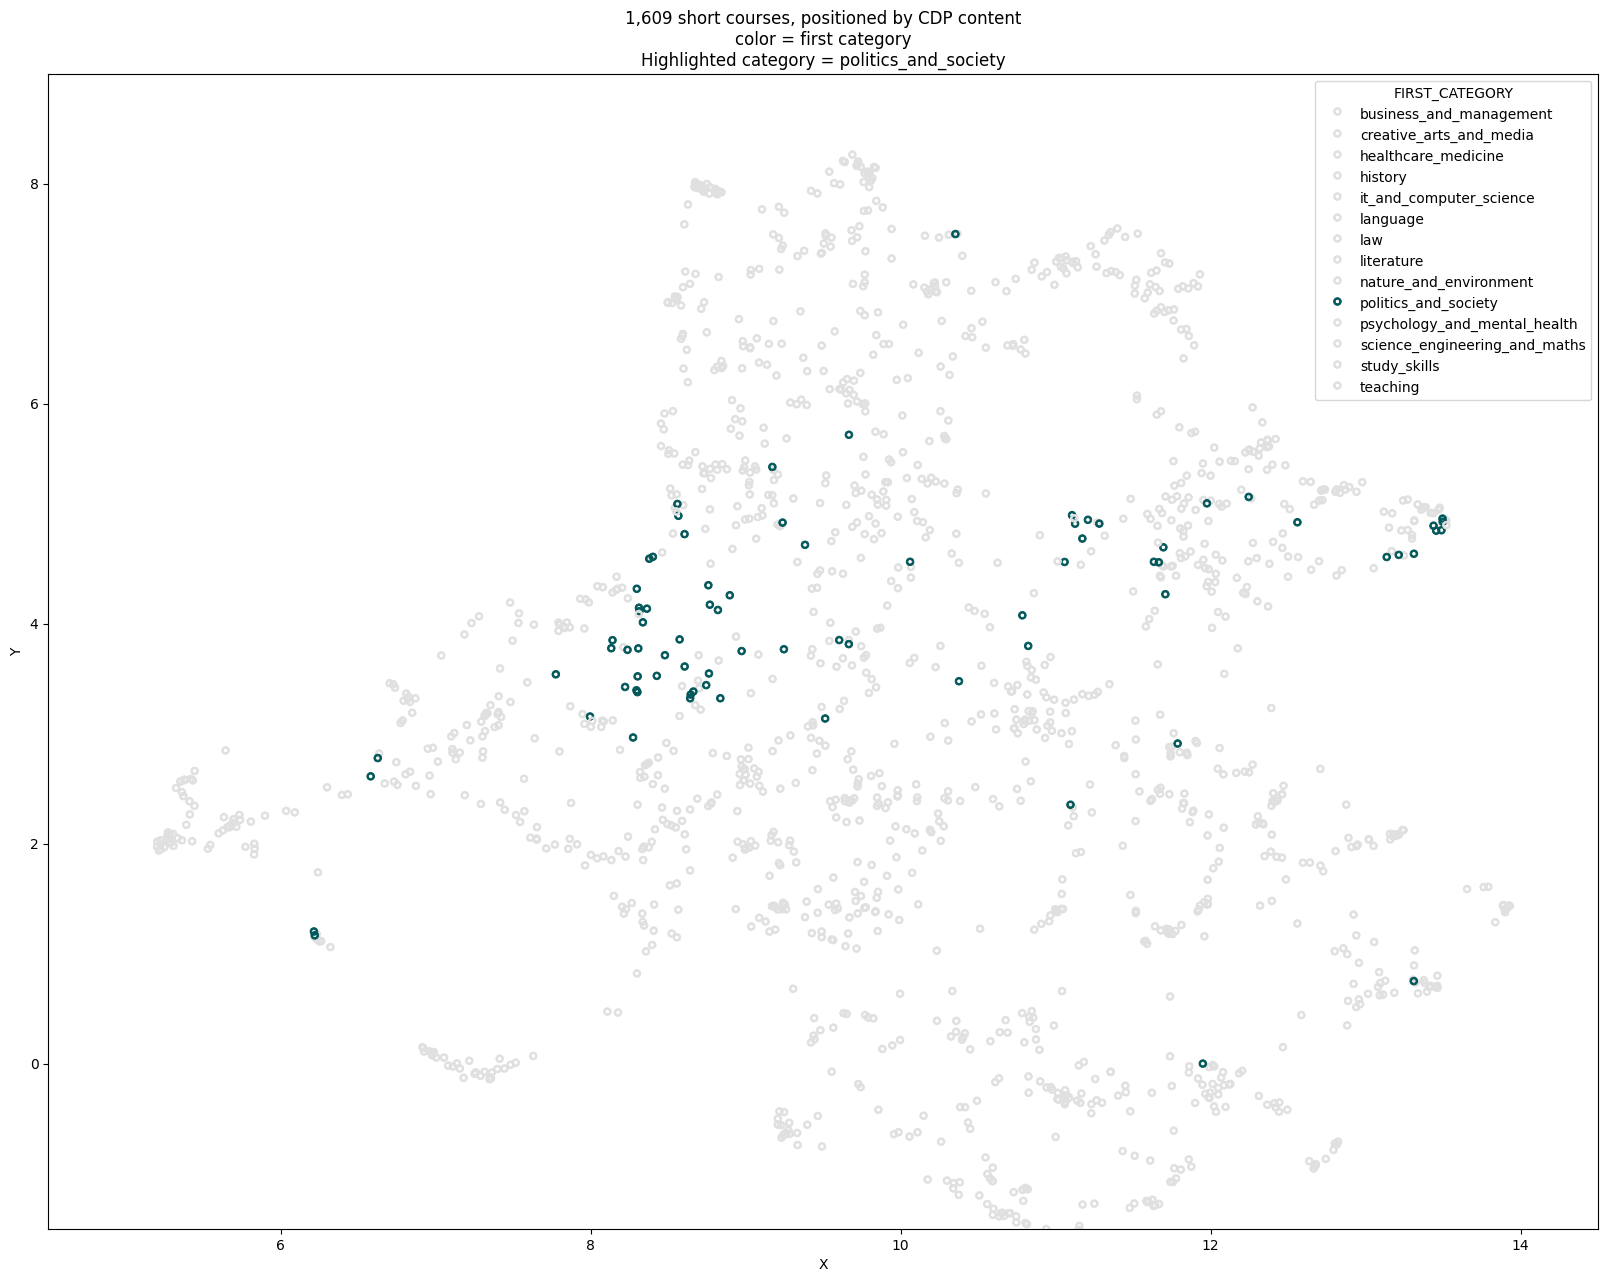

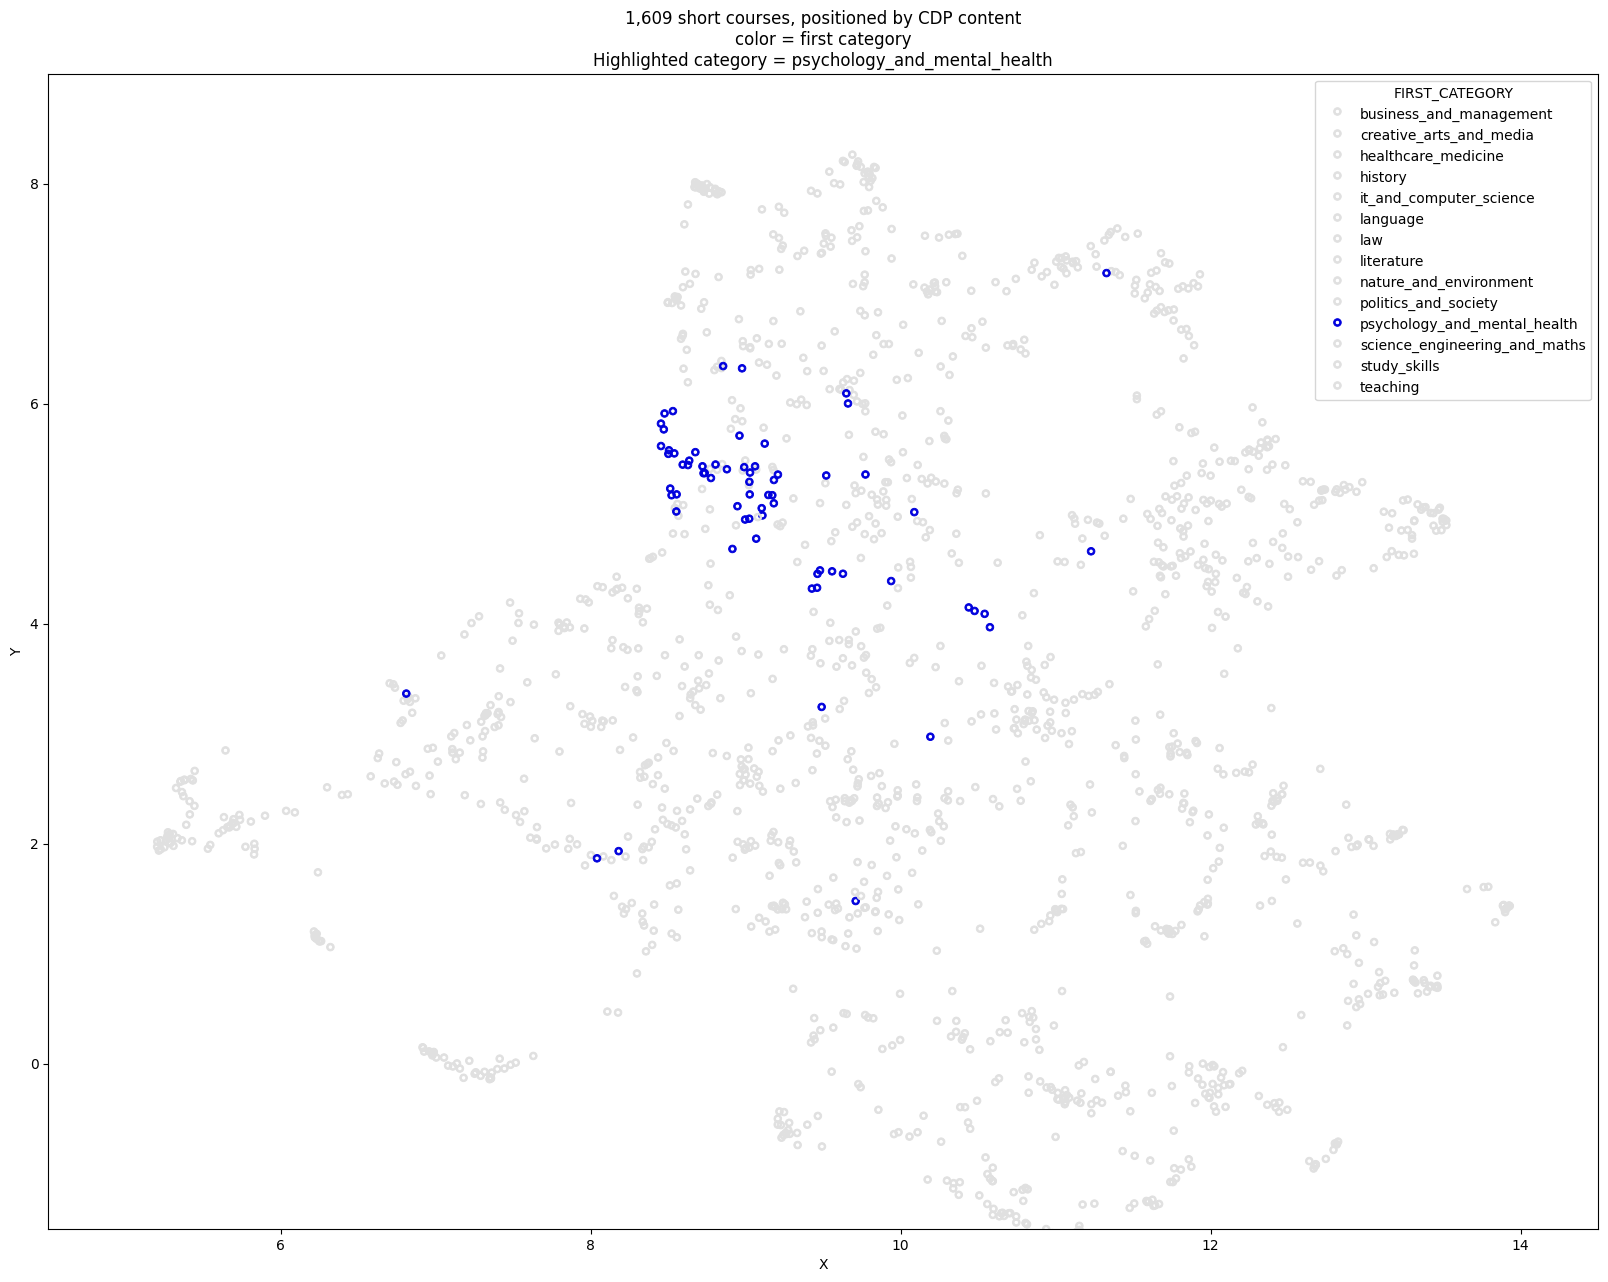

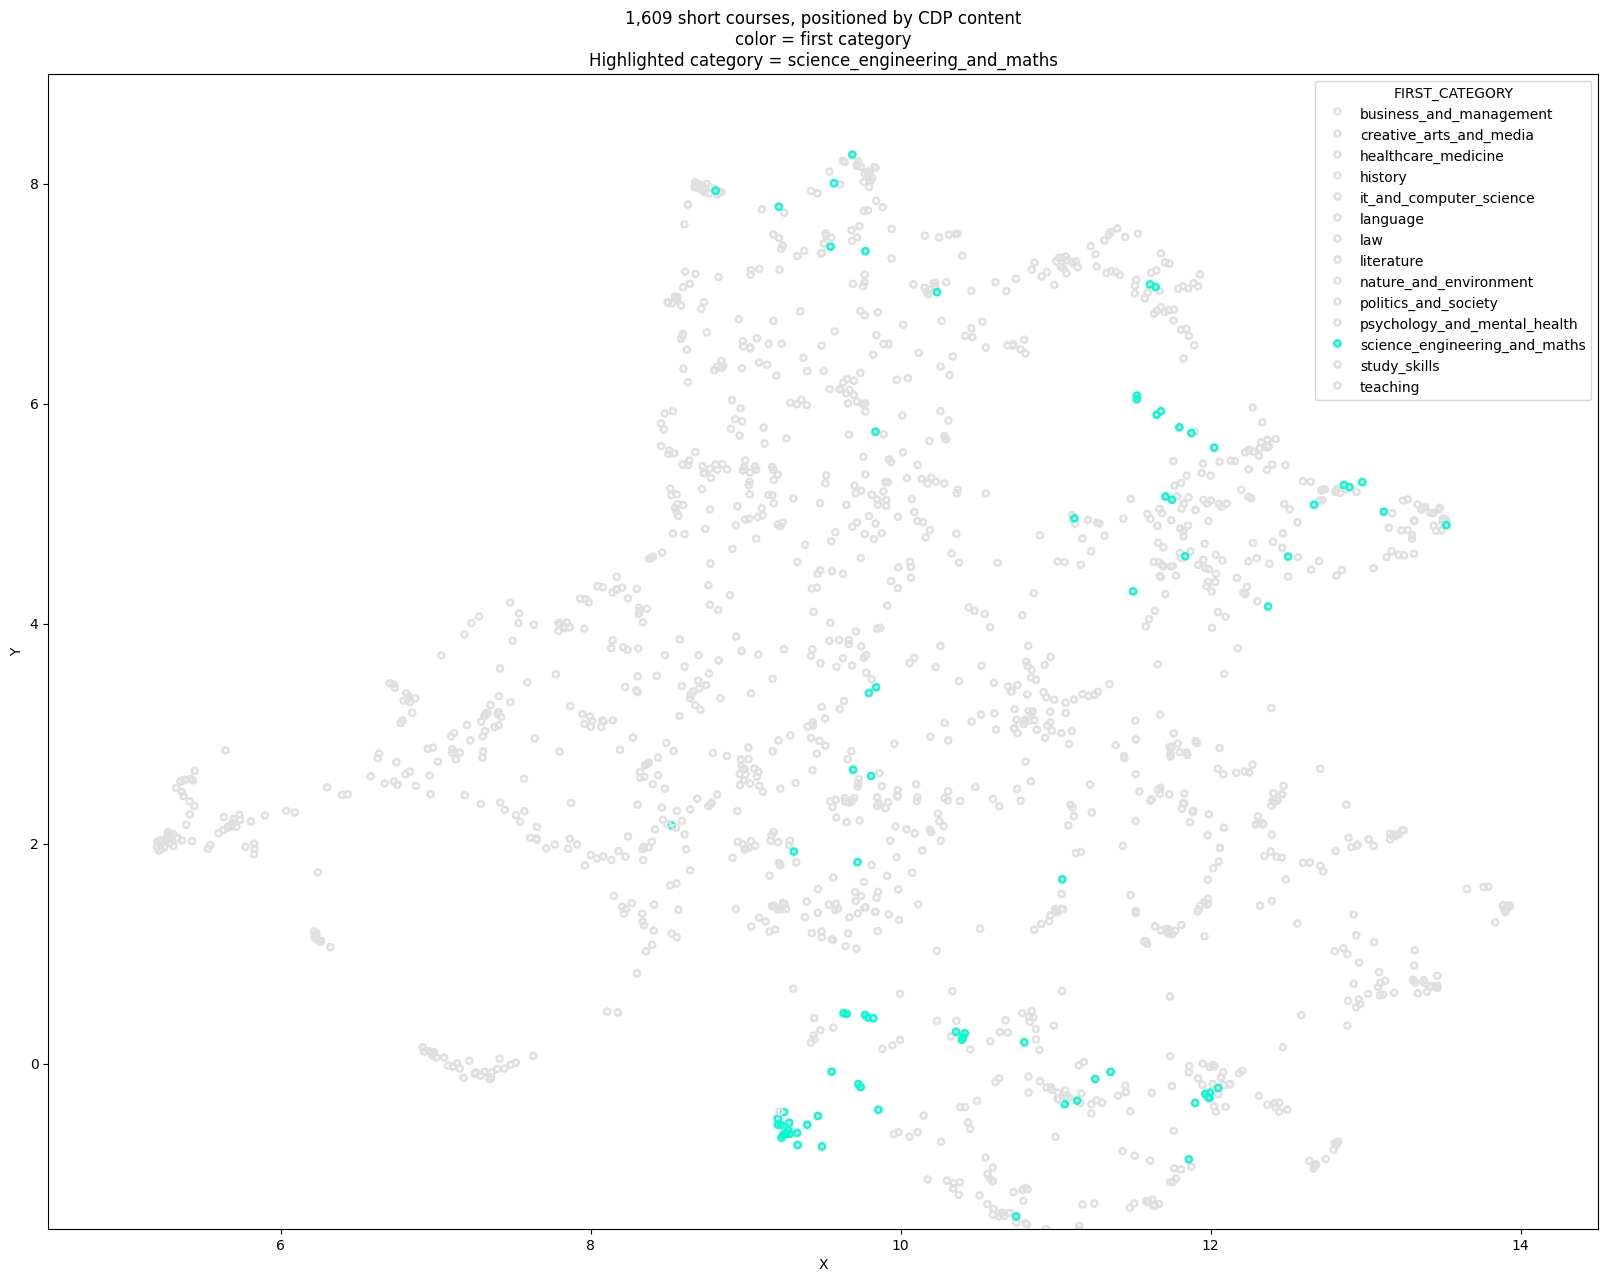

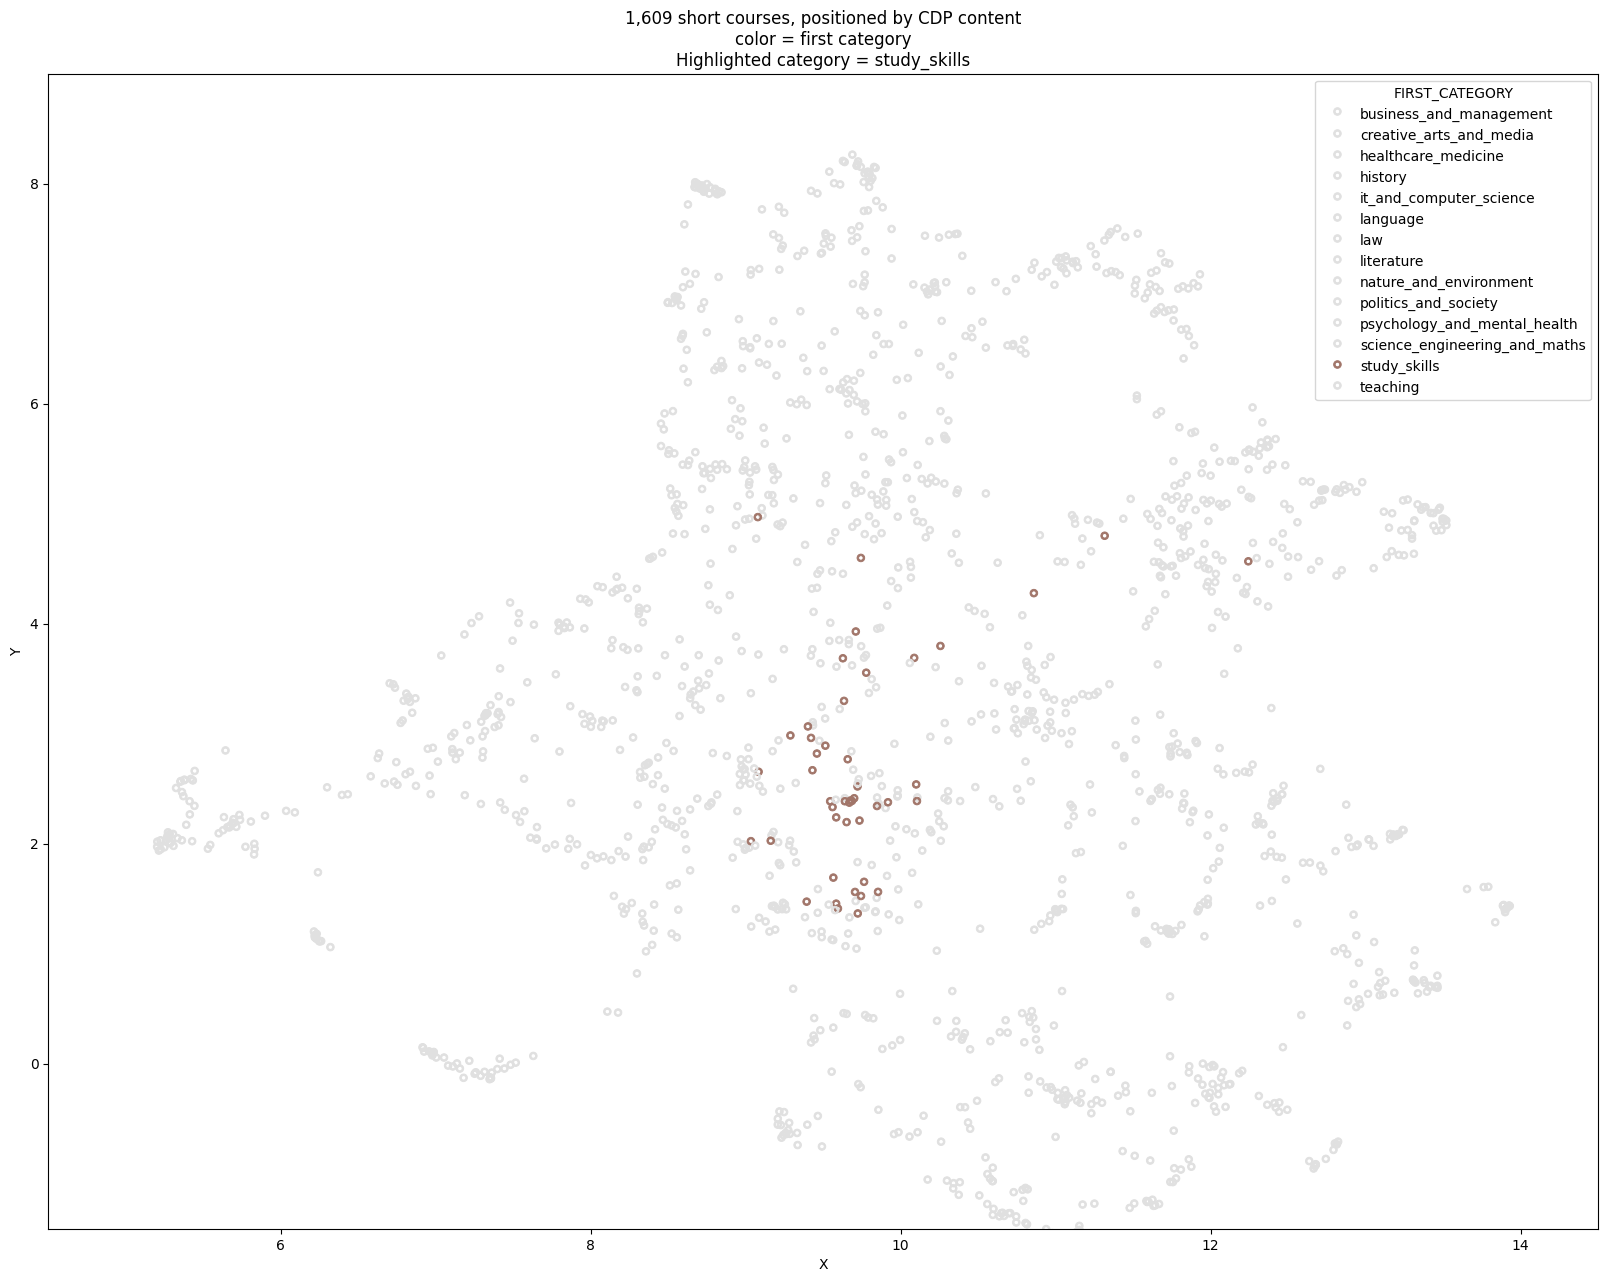

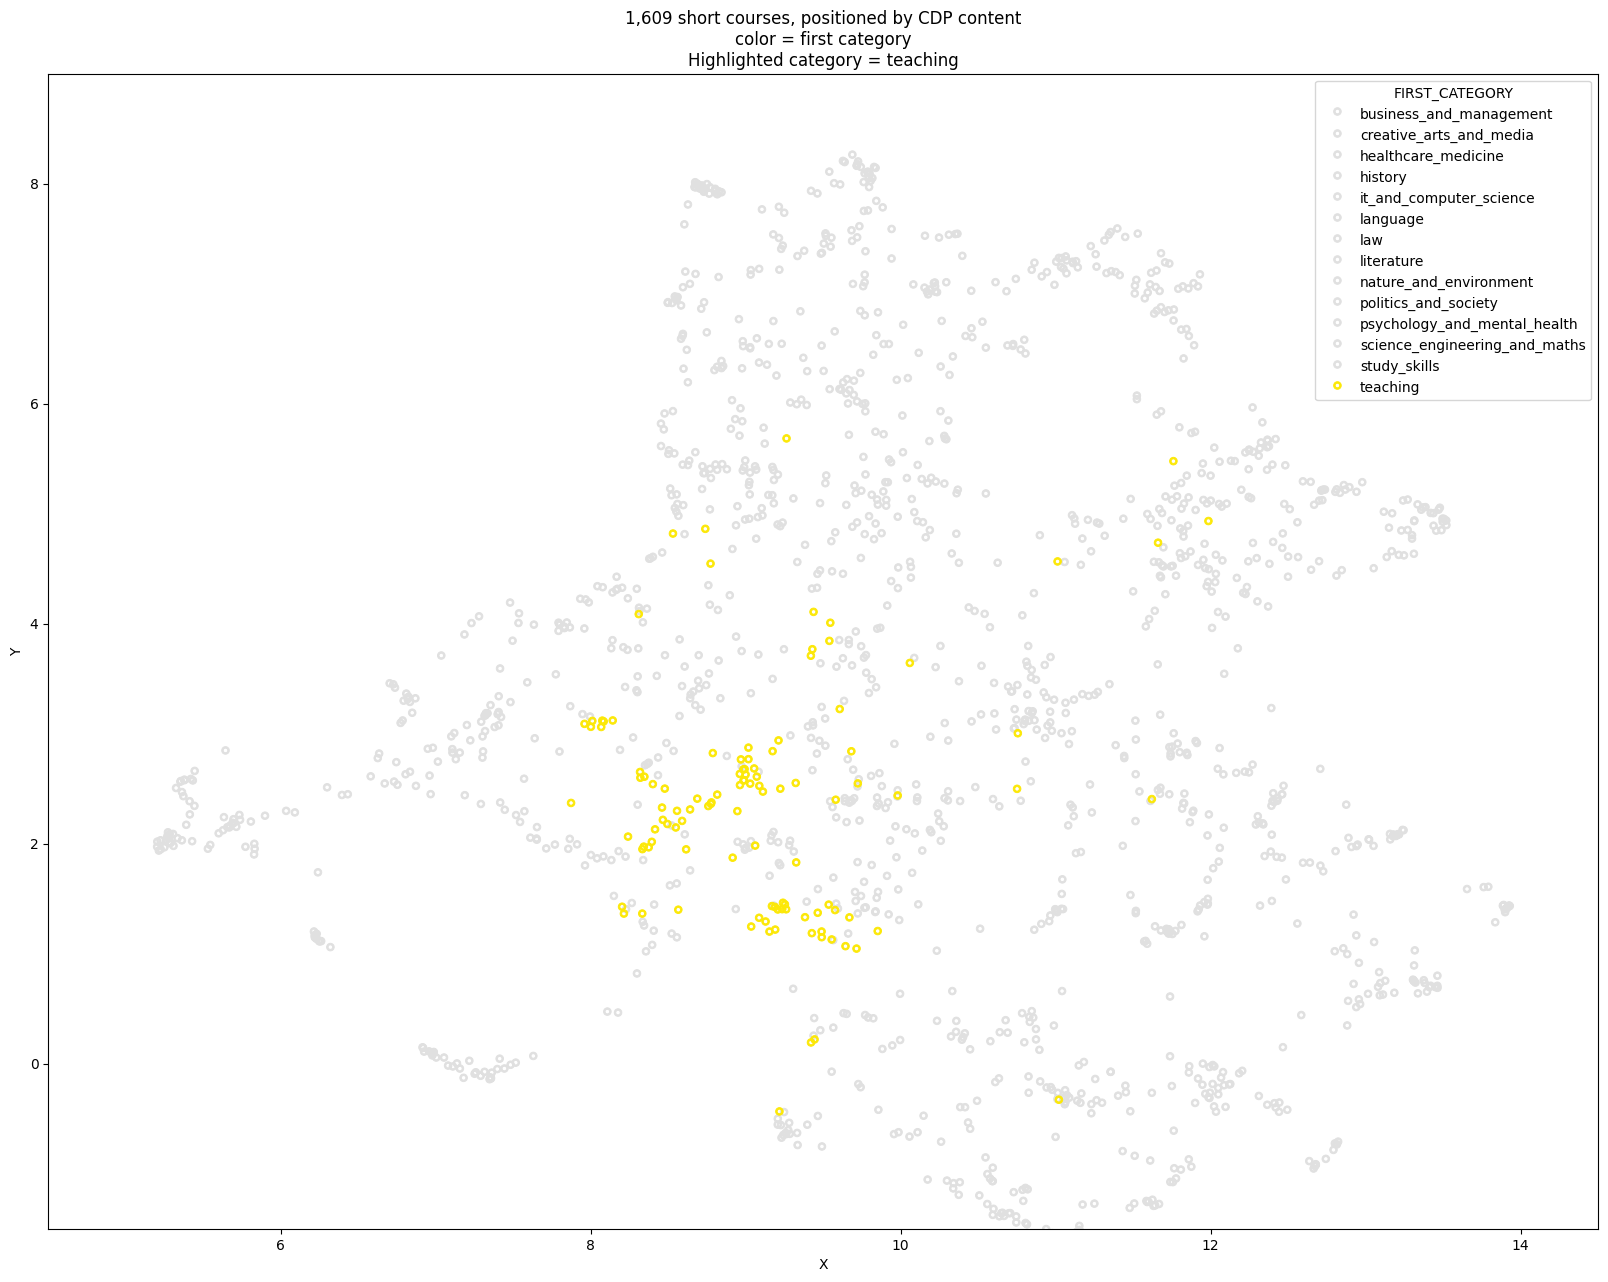

In [25]:
# plot and save all plot for categories
# NOTE: check ranges, if these should have been updated!

categories = ['business_and_management','creative_arts_and_media','healthcare_medicine','history','it_and_computer_science','language','law','literature','nature_and_environment','politics_and_society','psychology_and_mental_health','science_engineering_and_maths','study_skills','teaching']

for one_cat in categories:
    cat_to_highlight = one_cat
    cat_pos_to_highlight = categories.index(cat_to_highlight) # range [0-13]

    palette_orig = ['#d60000','#8c3bff','#018700','#00acc6','#97ff00','#ff7ed1','#6b004f','#ffa52f','#573b00','#005659','#0000dd','#00fdcf','#a17569','#fce807']
    palette_grey = ['#e0e0e0' for x in range(14)]
    palette = palette_grey
    palette[cat_pos_to_highlight] = palette_orig[cat_pos_to_highlight]

    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    g = sns.scatterplot(data=df,
                    x="X",
                    y="Y",
                    hue="FIRST_CATEGORY",
                    ax = ax,
                    palette=palette,
                    # the next lines make the markers hollow and outlined - to cater for overlapping of markers
                    ec="face",
                    marker="$\circ$",
                    s=70)

    ax.set_title('{:,}'.format(len(df))+" short courses, positioned by CDP content\ncolor = first category\nHighlighted category = "+cat_to_highlight)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    g.set(xlim=(4.5,14.5),ylim=(-1.5,9));

    # X: [4.5,14.5]
    # Y: [-1.5,9]

    file_name = "cat_"+cat_to_highlight
    fig.savefig("../img/"+file_name) 

    print("saved file "+file_name)

---

### Export data for each course category
Sorted by either the X or Y axis, depending on what makes more sense for the data in terms of making it easier for users to interpret and locate courses on the map.

In [26]:
df.FIRST_CATEGORY.unique()

<StringArray>
[      'business_and_management',       'creative_arts_and_media',
           'healthcare_medicine',                       'history',
       'it_and_computer_science',                      'language',
                           'law',                    'literature',
        'nature_and_environment',          'politics_and_society',
  'psychology_and_mental_health', 'science_engineering_and_maths',
                  'study_skills',                      'teaching']
Length: 14, dtype: string

In [27]:
# business and management
df[df.FIRST_CATEGORY == 'business_and_management'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='Y').to_csv("../data/business-category_sorted_Y.csv")

In [28]:
# creative_arts_and_media
df[df.FIRST_CATEGORY == 'creative_arts_and_media'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/creative-category_sorted_X.csv")

In [29]:
# healthcare_medicine
df[df.FIRST_CATEGORY == 'healthcare_medicine'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='Y').to_csv("../data/healthcare-category_sorted_Y.csv")

In [30]:
# history
df[df.FIRST_CATEGORY == 'history'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/history-category_sorted_X.csv")

In [31]:
# it_and_computer_science
df[df.FIRST_CATEGORY == 'it_and_computer_science'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/computer-category_sorted_X.csv")

In [32]:
# language
df[df.FIRST_CATEGORY == 'language'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/language-category_sorted_X.csv")

In [33]:
# law
df[df.FIRST_CATEGORY == 'law'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/law-category_sorted_X.csv")

In [34]:
# literature
df[df.FIRST_CATEGORY == 'literature'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/literature-category_sorted_X.csv")

In [35]:
# nature_and_environment
df[df.FIRST_CATEGORY == 'nature_and_environment'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/nature-category_sorted_X.csv")

In [36]:
# politics_and_society
df[df.FIRST_CATEGORY == 'politics_and_society'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/politics-category_sorted_X.csv")

In [37]:
# psychology_and_mental_health
df[df.FIRST_CATEGORY == 'psychology_and_mental_health'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/psychology-category_sorted_X.csv")

In [38]:
# science_engineering_and_maths
df[df.FIRST_CATEGORY == 'science_engineering_and_maths'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='Y').to_csv("../data/science-category_sorted_Y.csv")

In [39]:
# study_skills
df[df.FIRST_CATEGORY == 'study_skills'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='Y').to_csv("../data/study-category_sorted_Y.csv")

In [40]:
# teaching
df[df.FIRST_CATEGORY == 'teaching'][['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'DIFFICULTY_LEVEL','X', 'Y']].sort_values(by='X').to_csv("../data/teaching-category_sorted_X.csv")

## Can we cluster on the dim-reduced data?

### One approach: reduce dimensionality with UMAP, but with parameters optimised for clustering; then cluster this dim-reduced data
(following one of the official examples in the documentation)

Source: https://umap-learn.readthedocs.io/en/latest/clustering.html   

One advantage of UMAP for this is that it doesn’t require you to reduce to only two dimensions – you can reduce to 10 dimensions instead since the goal is to cluster, not visualize, and the performance cost with UMAP is minimal. In general you should explore different embedding dimension options.  

The next thing to be aware of is that when using UMAP for dimension reduction you will want to select different parameters than if you were using it for visualization. First of all we will want a larger n_neighbors value – small values will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters. In this case we’ll double it from the default 15 up to 30. Second it is beneficial to set min_dist to a very low value. Since we actually want to pack points together densely (density is what we want after all) a low value will help, as well as making cleaner separations between clusters. In this case we will simply set min_dist to be 0.

---

**HDBSCAN** - Hierarchical Density-Based Spatial Clustering of Applications with Noise. Performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection.

In practice this means that HDBSCAN returns a good clustering straight away with little or no parameter tuning – and the primary parameter, minimum cluster size, is intuitive and easy to select.

HDBSCAN is ideal for exploratory data analysis; it’s a fast and robust algorithm that you can trust to return meaningful clusters (if there are any).

In [30]:
import hdbscan

In [31]:
# following the official tutorial on UMAP, we create a separate, higher than 2-dim latent space with UMAP, that 
# should be capturing more relevant data info better than 2 dimensions only, making it better suited for clustering

# the parameter n_components sets the number of dimensions

reducer_10_dim = umap.UMAP(n_neighbors=10,min_dist=0.0,n_components=10,random_state=42)
reducer_10_dim.fit(np.array(df.embeddings.to_list()))
embedding_10_dim = reducer_10_dim.transform(np.array(df.embeddings.to_list()))


/opt/homebrew/Cellar/jupyterlab/4.0.9_2/libexec/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [32]:
# INFO: to access the embeddings, we can either run
# reducer_10_dim.embedding_
# or
# embedding_10_dim

# for 10 dimensions, there data will look like
# array([[0.7340375 , 2.579216  , 7.603244  , ..., 7.317868  , 5.8778415 ,
#         4.6924863 ],
#        [3.8433006 , 4.1463246 , 5.5291142 , ..., 7.659532  , 6.3529205 ,
#         4.8457985 ],
#         ...
#         [2.7457078 , 4.131059  , 4.738127  , ..., 7.155942  , 6.395934  ,
#         4.7843795 ]], dtype=float32)

---

Export the embedding dataset and the model, for future use

In [33]:
df_for_export = df[['COURSE_SLUG', 'COURSE_NAME', 'FIRST_CATEGORY', 'SECOND_CATEGORY',
       'TOPICS_ARRAY', 'CATEGORIES_ARRAY', 'DIFFICULTY_LEVEL',
       'concatenated_cdp_content', 'embeddings']].copy()
df_for_export.reset_index(inplace=True,drop=True)
df_for_export.head(2)

COURSE_SLUG           COURSE_NAME  \
0  dental-photography-in-practice  Improving Your Image   
1              discover-dentistry    Discover Dentistry   

            FIRST_CATEGORY                SECOND_CATEGORY  \
0  creative_arts_and_media            healthcare_medicine   
1      healthcare_medicine  science_engineering_and_maths   

                                        TOPICS_ARRAY  \
0  [Photography & Visual Arts, Medical Technology...   
1  [Biology & Biotechnology, Medical Technology, ...   

                                    CATEGORIES_ARRAY DIFFICULTY_LEVEL  \
0     [Creative Arts & Media, Healthcare & Medicine]             Open   
1  [Healthcare & Medicine, Science, Engineering &...             Open   

                            concatenated_cdp_content  \
0  Improving Your Image Learn how to achieve cons...   
1  Discover Dentistry Discover the fascinating wo...   

                                          embeddings  
0  [-0.00486373994499445, 0.029568398371338844, 0...  
1  [-0.0015590257244184613, 0.0030560169834643602...

In [34]:
df_for_export = pd.concat([df_for_export,pd.DataFrame(embedding_10_dim)],axis=1)
df_for_export.sample(2)                    

COURSE_SLUG  \
1125  pharmacy-for-beginners   
1671              systems-go   

                                            COURSE_NAME       FIRST_CATEGORY  \
1125                             Pharmacy for Beginners  healthcare_medicine   
1671  Systems Go! Cross-sector Partnering for Change...  healthcare_medicine   

              SECOND_CATEGORY  \
1125                     <NA>   
1671  business_and_management   

                                           TOPICS_ARRAY  \
1125                           [Primary Care, Pharmacy]   
1671  [Leadership in Healthcare, Communication, Soft...   

                                    CATEGORIES_ARRAY DIFFICULTY_LEVEL  \
1125                         [Healthcare & Medicine]     Introductory   
1671  [Healthcare & Medicine, Business & Management]     Introductory   

                               concatenated_cdp_content  \
1125  Pharmacy for Beginners Gain a basic understand...   
1671  Systems Go! Cross-sector Partnering for Change...   

                                             embeddings         0         1  \
1125  [0.02328207902610302, 0.004761656280606985, -0...  8.316507  6.445652   
1671  [0.01865578442811966, 0.007217153441160917, -0...  8.886068  5.222028   

             2         3         4         5         6         7         8  \
1125  6.436994  5.812892  4.128221  6.847304  4.823653  6.282906  4.403401   
1671  6.439030  6.154223  3.848444  6.166849  4.209828  6.265801  4.532851   

             9  
1125  4.366531  
1671  4.156464

In [35]:
df_for_export.tail(2)

COURSE_SLUG  \
1681      sustainable-management-in-extractive-industry   
1682  digital-literacy-sustainable-development-in-th...   

                                            COURSE_NAME  \
1681  Sustainable Management in the Extractive Industry   
1682  Digital Literacy: Sustainable Development in t...   

               FIRST_CATEGORY          SECOND_CATEGORY  \
1681   nature_and_environment  business_and_management   
1682  it_and_computer_science     politics_and_society   

                                           TOPICS_ARRAY  \
1681  [Geology, Conservation, Ecology, Business Stra...   
1682        [Environmental Issues, Business Technology]   

                                   CATEGORIES_ARRAY DIFFICULTY_LEVEL  \
1681  [Nature & Environment, Business & Management]         Advanced   
1682    [Politics & Society, IT & Computer Science]     Introductory   

                               concatenated_cdp_content  \
1681  Sustainable Management in the Extractive Indus...   
1682  Digital Literacy: Sustainable Development in t...   

                                             embeddings         0         1  \
1681  [0.018492795526981354, -0.010805540718138218, ...  8.109460  4.004462   
1682  [0.017771435901522636, 0.004061025567352772, 0...  9.298201  3.374527   

             2         3         4         5         6         7         8  \
1681  6.309105  7.939323  2.594325  6.380535  3.703272  5.186390  4.630292   
1682  7.547272  5.646888  4.895904  6.345828  4.039441  5.501918  3.739320   

             9  
1681  3.905419  
1682  3.472046

In [36]:
# save dataset
df_for_export.to_pickle('../data/short-courses-UMAP-10dim-embeddings.pkl')

OSError: Cannot save file into a non-existent directory: '../data'

In [37]:
# export model
file_name = 'short-courses-umap-10-dim-model.sav'
pickle.dump(reducer_10_dim, open('../data/'+file_name, 'wb'))

# how to load later:
# loaded_model = pickle.load((open(file_name, 'rb')))

FileNotFoundError: [Errno 2] No such file or directory: '../data/short-courses-umap-10-dim-model.sav'

---

In [38]:
# the settings are aiming to get roughly 15 clusters, similar to existing number of categories

labels = hdbscan.HDBSCAN(min_cluster_size=35,min_samples=5).fit_predict(embedding_10_dim)
pd.Series(labels).nunique()

19

In [39]:
pd.Series(labels).value_counts().sort_index()

-1     205
 0     227
 1      59
 2      99
 3      91
 4     190
 5      54
 6      63
 7      66
 8     108
 9      37
 10     36
 11     48
 12     54
 13     87
 14     58
 15    101
 16     44
 17     56
Name: count, dtype: int64

Importantly HDBSCAN is noise aware – it has a notion of data samples that are not assigned to any cluster. This is handled by assigning these samples the label -1. But wait, there’s more. The hdbscan library implements soft clustering, where each data point is assigned a cluster membership score ranging from 0.0 to 1.0. A score of 0.0 represents a sample that is not in the cluster at all (all noise points will get this score) while a score of 1.0 represents a sample that is at the heart of the cluster (note that this is not the spatial centroid notion of core). You can access these scores via the probabilities_ attribute.

In [40]:
# value -1 is for outliers
clustered = (labels >= 0)

In [41]:
df["cluster_labels"] = labels

ValueError: Could not interpret value `X` for `x`. An entry with this name does not appear in `data`.

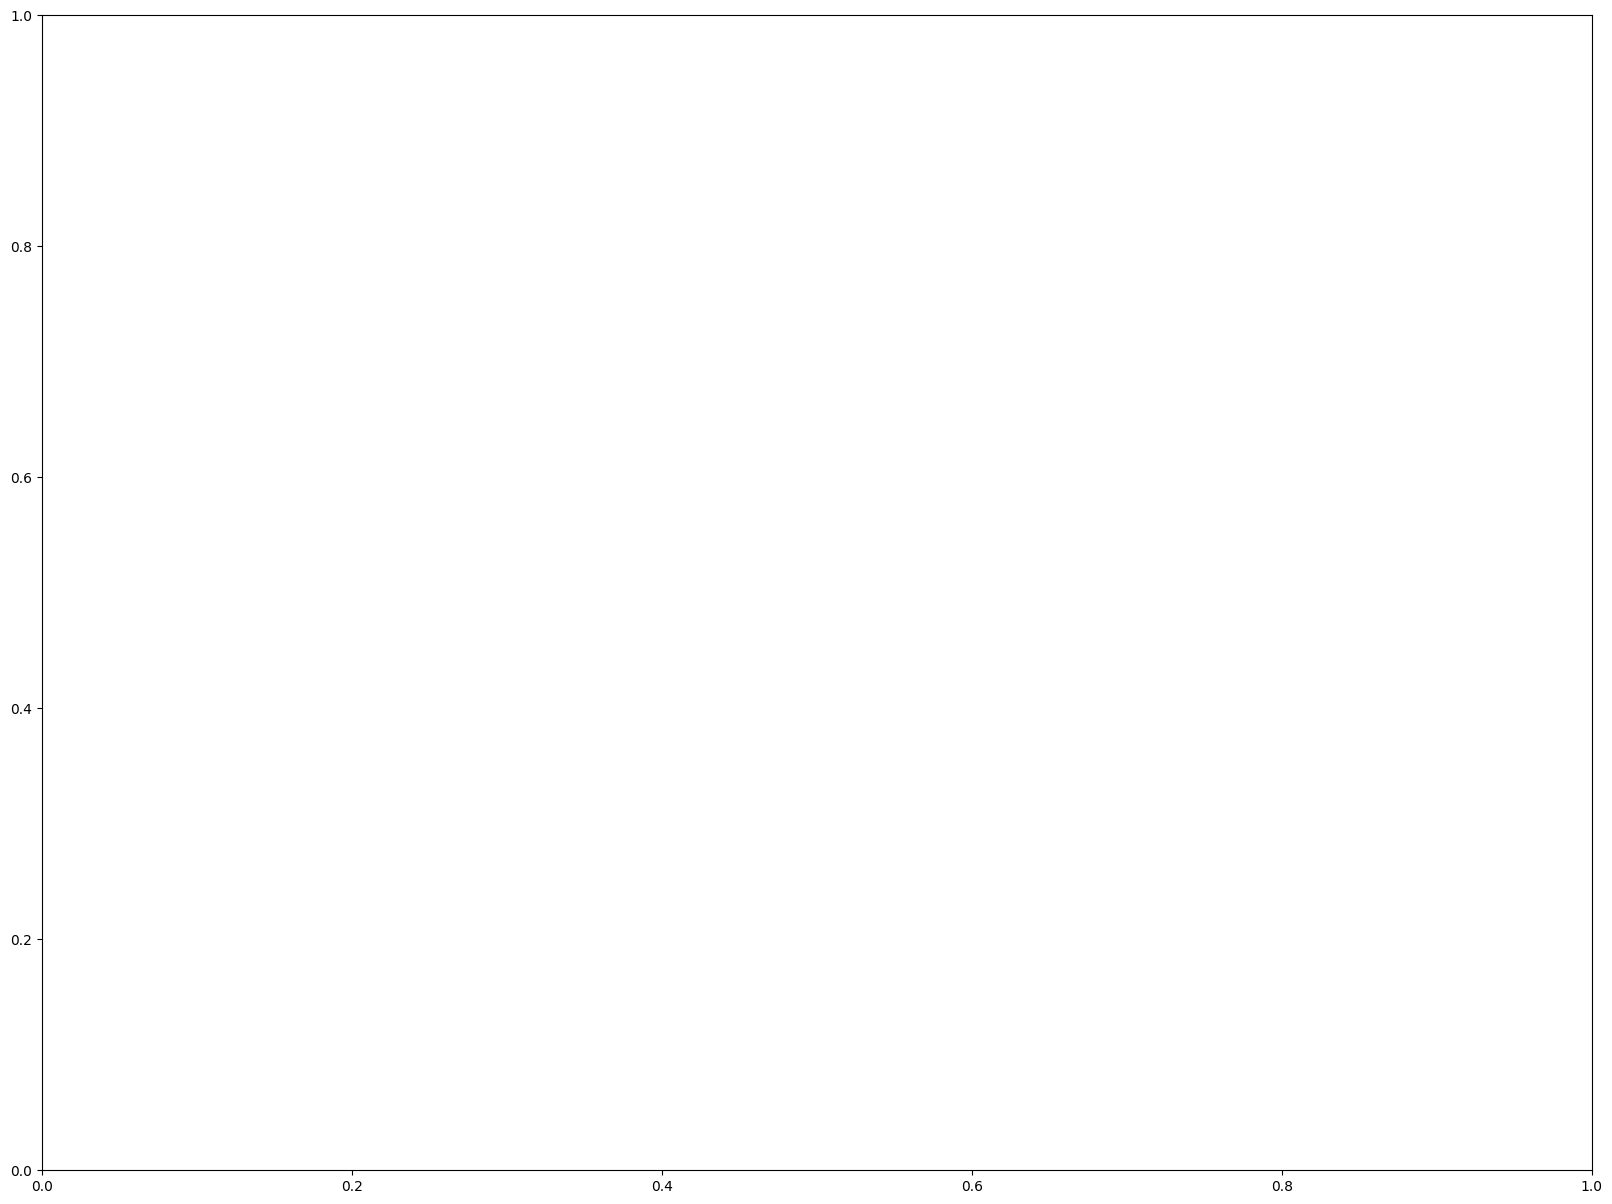

In [42]:
# plot outliers as grey crosses
# and clusters in different colours

n_clusters = df[clustered].cluster_labels.nunique()
n_clustered = len(df[clustered])
n_outliers = len(df[~clustered])
palette = sns.color_palette(cc.glasbey, n_colors=n_clusters)
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
g1 = sns.scatterplot(data=df[~clustered],
                x="X",
                y="Y",
                ax = ax,
                color=(0.5, 0.5, 0.5),
                marker = 'x')
g2 = g1 = sns.scatterplot(data=df[clustered],
                x="X",
                y="Y",
                hue="cluster_labels",
                palette=palette,
                ax = ax)
ax.set_title('{:,}'.format(len(df))+" short courses, positioned by CDP content\n"+'{:,}'.format(n_clustered)+" courses clustered into "+str(n_clusters)+" content-similar groups, with " + '{:,}'.format(n_outliers) +" outliers.")
ax.set_xlabel("X")
ax.set_ylabel("Y")
g.set(xlim=(4.5,14.5),ylim=(-1.5,9));


    # X: [4.5,14.5]
    # Y: [-1.5,9]

file_name = "hdbscan_clusters_"+str(n_clusters)
fig.savefig("../img/"+file_name) 

## Clusterig on high-dimensional data, then UMAP-reduce

INFO: that was an approach, but it did not work out.

The approach above applied dim-reduction with UMAP with a focus on clusters, then HDBSCAN on thiese embeddings, and then maps the cluster labels back to the initial 2-dim embeddings of UMAP. It seems a bit convoluted and adds yet another set of hyperparameters to tune...

Is there  a possibility to cluster with HDBSCAN directly on the embeddings, and then visualise on the UMAP dimensions?   
Are the cluster detected different?

---

### Can we describe these clusters somehow?

Idea: use the topic arrays of contained courses, and diplay them as a word cloud

In [43]:
# one cluster
cluster_0 = df[df.cluster_labels == 0]
len(cluster_0)

227

In [44]:
cluster_0.TOPICS_ARRAY

13                                       [Cyber Security]
44                                        [AI & Robotics]
81                       [Medical Technology, Statistics]
83                                 [Coding & Programming]
88                                       [Data Analytics]
                              ...                        
1648    [Data Visualisation, Data Analysis, Data Analy...
1654                      [Bioinformatics, Data Analysis]
1659                                                 [HR]
1666    [Generative AI, Artificial Intelligence (AI), ...
1669                      [FinTech, Software Development]
Name: TOPICS_ARRAY, Length: 227, dtype: object

Tutorial for word cloud: https://dataanalysis.substack.com/p/generating-a-word-cloud-in-python

In [45]:
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

In [46]:
# first approach: using all words independently

#word_string = cluster_0.TOPICS_ARRAY.apply(lambda x: " ".join(x)).str.cat(sep=" ")
#word_string

In [47]:
import multidict as multidict
import re
from  itertools import chain 

ModuleNotFoundError: No module named 'multidict'

In [48]:
 # second approach: generate cloud from frequencies, since we do not want a term like 'Articficial Intelligence' to be
# treated like two separate words of 'Artificial' and 'Intelligence'

In [49]:
list_of_terms = list(chain.from_iterable(cluster_0.TOPICS_ARRAY))
dict_of_terms = pd.Series(list_of_terms).value_counts().to_dict()
wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict_of_terms)

NameError: name 'chain' is not defined

NameError: name 'wordcloud' is not defined

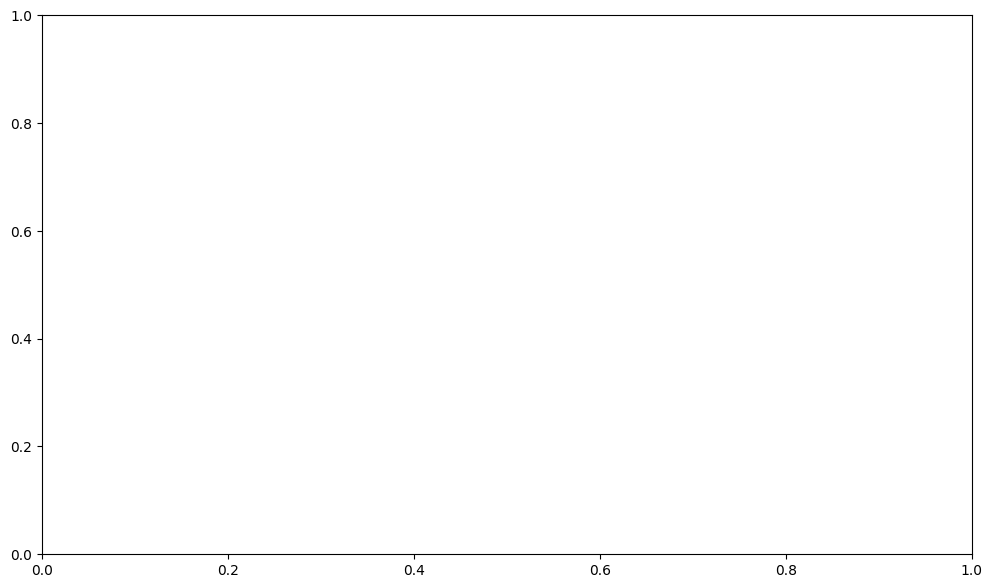

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.imshow(wordcloud, interpolation="bilinear", figure=fig)
plt.axis("off");
#plt.savefig("../img/word_cloud_cluster_0")

In [51]:
# now for all clusters

In [52]:
# save the dictionary of words in cluster - for future work
#pd.DataFrame.from_dict(dict_of_terms,orient='index',columns=['word_count_in_cluster']).to_pickle()

In [53]:
no_of_clusters = df.cluster_labels.nunique()
labels_of_clusters = np.sort(df.cluster_labels.unique())

# we need to exclude the 'outlier' cluster
if np.isin((-1),labels_of_clusters):
    no_of_clusters = no_of_clusters-1
    labels_of_clusters = labels_of_clusters[1:]

for cluster_label in labels_of_clusters:
    cluster = df[df.cluster_labels == cluster_label]

    list_of_terms = list(chain.from_iterable(cluster.TOPICS_ARRAY))
    dict_of_terms = pd.Series(list_of_terms).value_counts().to_dict()

    # save disctionary for future use pr deeper exploration
    pd.DataFrame.from_dict(dict_of_terms,orient='index',columns=['word_count_in_cluster']).to_pickle(f"../data/dict_cluster_{cluster_label}.pkl")

    # plot and save image
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict_of_terms)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(f"../img/word_cloud_cluster_{cluster_label}")

NameError: name 'chain' is not defined

The plot above could equally be coloured by other course info:
* average course rating
* number of learners in last year
* course creating partner
* keywords in topic array (for example 'data analysis' and 'data science')
* GMV
* Completion rate
* CDP views
* Number of searches for degrees (I enrolled in course A, and then looked for a degree course)
* heavily subscribed courses, but that don't have follow-on courses
* low subscribed but many 
* many courses in silimar area but under-subscribed

7 priority topics as centroid
- which courses are in that categroey, and which ones are in the wrong category

Comparison of current portfolio to last year's portfolio